In [ ]:
# w = 15 로 돌려보자
# lr = 0.0001

In [1]:
# 모듈 import
from datetime import datetime
import numpy as np
import os
import pandas as pd

#from google.colab import drive
#drive.mount('/content/gdrive')
#os.chdir('/content/gdrive/MyDrive/python/python_dong/data_axis_transform1')

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

#!pip install torchmetrics
import torchmetrics

#!pip install torchinfo
from torchinfo import summary

import matplotlib.pyplot as plt
import math


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# 1. 데이터 전처리

In [2]:
# data path 지정
raw_data_path = './data/stocknet-dataset/price/raw'

if 'stocknet' in raw_data_path:
    tra_date = '2014-01-02'
    val_date = '2015-08-03'
    tes_date = '2015-10-01'
    end_date = '2015-12-31'
elif 'kdd17' in raw_data_path:
    tra_date = '2007-01-03'
    val_date = '2015-01-02'
    tes_date = '2016-01-04'
    end_date = '2016-12-31'
else:
    print('unexpected path: %s' % raw_data_path)

# os.path.isfile : 파일이 있는지 없는 지 체크
# os.path.join(data_path, fname) : 폴더 디렉터리와 fname(stockname.csv) 붙임
fnames = [fname for fname in os.listdir(raw_data_path) if
            os.path.isfile(os.path.join(raw_data_path,fname))]

COLUMNS_FEATURE_DATA_V1 = ['open_close_ratio', 'high_close_ratio', 
                           'low_close_ratio', 'close_lastclose_ratio', 
                           'adjclose_lastadjclose_ratio', 'close_ma5_ratio', 
                           'close_ma10_ratio', 'close_ma15_ratio', 'close_ma20_ratio', 
                           'close_ma25_ratio', 'close_ma30_ratio']

ver = 'v1' # ver in ['v1', 'v2']
if ver == 'v1':
    COLUMNS_FEATURE = COLUMNS_FEATURE_DATA_V1

In [3]:
windows = [5,10,15,20,25,30]

def preprocess(df, windows):
   '''
   전처리 함수 역할 : 전체 feature생성하여 df column에 추가
   '''
   data = df
   data['open_close_ratio'] = data['Open'] / data['Close'] - 1
   data['high_close_ratio'] = data['High'] / data['Close'] - 1
   data['low_close_ratio'] = data['Low'] / data['Close'] - 1

   data['close_lastclose_ratio'] = np.zeros(len(data))
   data.loc[1:, 'close_lastclose_ratio'] = data['Close'][1:].values / data['Close'][:-1].values - 1

   data['adjclose_lastadjclose_ratio'] = np.zeros(len(data))
   data.loc[1:, 'adjclose_lastadjclose_ratio'] = data['Adj Close'][1:].values / data['Adj Close'][:-1].values - 1

   for window in windows:
      data[f'close_ma{window}_ratio'] = data['Adj Close'].rolling(window).mean()/data['Adj Close'] - 1
   
   data['label'] = np.append((data['Close'][1:].values > data['Close'][:-1].values)*1,0)

   return data

In [4]:
feature_data_path = './data/stocknet-dataset/price/feature'

for fname in fnames:
   if not os.path.isfile(os.path.join(feature_data_path,fname)):
      df_raw = pd.read_csv(os.path.join(raw_data_path,fname))
      data = preprocess(df_raw, windows)

      # 폴더 없으면 생성
      try:
         if not os.path.exists(feature_data_path):
            os.makedirs(feature_data_path)
      except OSError:
         print ('Error: Creating directory. ' +  feature_data_path)

      #csv 파일 저장
      data.to_csv(os.path.join(feature_data_path,fname))



# train, validation, test data 나누기

## 1. input data 3차원으로 쌓기
shape = (stock 종류수, date, feature)



요건
1. 모든 티커 데이터의 date가 맞는지?
2. 결측치는 없는지?
3. 티커와 데이터 메치 가능해야함

In [5]:
raw_data_path = './data/stocknet-dataset/price/raw'


tra_data_X = []
tra_data_Y = []
val_data_X = []
val_data_Y = []
test_data_X = []
test_data_Y = []
tickers = []

cnt = 0
fail_cnt = 0

fnames = [fname for fname in os.listdir(raw_data_path) if
            os.path.isfile(os.path.join(raw_data_path,fname))]

for fname in fnames:

    df = pd.read_csv(os.path.join(raw_data_path,fname))
    data = preprocess(df, windows)

    learning_data = data[(data['Date'] >= tra_date) & (data['Date'] <= end_date)]['Date']
    tra_data_X_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)][COLUMNS_FEATURE]
    tra_data_Y_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)]['label']

    val_data_X_ticker = data[(data['Date'] >= val_date) & (data['Date'] < tes_date)][COLUMNS_FEATURE]
    val_data_Y_ticker = data[(data['Date'] >= val_date) & (data['Date'] < tes_date)]['label']

    test_data_X_ticker = data[(data['Date'] >= tes_date) & (data['Date'] <= end_date)][COLUMNS_FEATURE]
    test_data_Y_ticker = data[(data['Date'] >= tes_date) & (data['Date'] <= end_date)]['label']


    if cnt == 0:
        target_dates = learning_data
    
    print('ticker : {}, date check : {}'.format(fname, np.array_equal(target_dates.values, learning_data.values)))
    if np.array_equal(target_dates.values, learning_data.values): 
        
        tra_data_X.append(tra_data_X_ticker.values)
        tra_data_Y.append(tra_data_Y_ticker.values)

        val_data_X.append(val_data_X_ticker.values)
        val_data_Y.append(val_data_Y_ticker.values)
        
        test_data_X.append(test_data_X_ticker.values)
        test_data_Y.append(test_data_Y_ticker.values)

        tickers.append(fname)
    else : 
        fail_cnt += 1
    
    cnt += 1

print(cnt, len(fnames))
print('fail_cnt :', fail_cnt)

# 마지막에 index 종목 넣기
raw_data_index_path = './data/stocknet-dataset/price/raw/index'

fname = os.listdir(raw_data_index_path)[0]

df = pd.read_csv(os.path.join(raw_data_index_path,fname))
data = preprocess(df, windows)

learning_data = data[(data['Date'] >= tra_date) & (data['Date'] <= end_date)]['Date']
tra_data_X_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)][COLUMNS_FEATURE]
tra_data_Y_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)]['label']

val_data_X_ticker = data[(data['Date'] >= val_date) & (data['Date'] < tes_date)][COLUMNS_FEATURE]
val_data_Y_ticker = data[(data['Date'] >= val_date) & (data['Date'] < tes_date)]['label']

test_data_X_ticker = data[(data['Date'] >= tes_date) & (data['Date'] <= end_date)][COLUMNS_FEATURE]
test_data_Y_ticker = data[(data['Date'] >= tes_date) & (data['Date'] <= end_date)]['label']

print('ticker : {}, date check : {}'.format(fname, np.array_equal(target_dates.values, learning_data.values)))
if np.array_equal(target_dates.values, learning_data.values):
    
    tra_data_X.append(tra_data_X_ticker.values)
    # tra_data_Y.append(tra_data_Y_ticker.values)

    val_data_X.append(val_data_X_ticker.values)
    # val_data_Y.append(val_data_Y_ticker.values)
    
    test_data_X.append(test_data_X_ticker.values)
    # test_data_Y.append(test_data_Y_ticker.values)

    tickers.append(fname)

# tra_data_X

ticker : AAPL.csv, date check : True
ticker : ABB.csv, date check : True
ticker : ABBV.csv, date check : True
ticker : AEP.csv, date check : True
ticker : AGFS.csv, date check : False
ticker : AMGN.csv, date check : True
ticker : AMZN.csv, date check : True
ticker : BA.csv, date check : True
ticker : BABA.csv, date check : False
ticker : BAC.csv, date check : True
ticker : BBL.csv, date check : True
ticker : BCH.csv, date check : True
ticker : BHP.csv, date check : True
ticker : BP.csv, date check : True
ticker : BRK-A.csv, date check : True
ticker : BSAC.csv, date check : True
ticker : BUD.csv, date check : True
ticker : C.csv, date check : True
ticker : CAT.csv, date check : True
ticker : CELG.csv, date check : True
ticker : CHL.csv, date check : True
ticker : CHTR.csv, date check : True
ticker : CMCSA.csv, date check : True
ticker : CODI.csv, date check : True
ticker : CSCO.csv, date check : True
ticker : CVX.csv, date check : True
ticker : D.csv, date check : True
ticker : DHR.csv,

In [6]:
def list_to_tensor(list_):
    return torch.Tensor(np.array(list_))

In [7]:
tensor_tra_data_X = list_to_tensor(tra_data_X)
tensor_tra_data_Y = list_to_tensor(tra_data_Y).view((len(tra_data_Y),-1,1))
tensor_val_data_X = list_to_tensor(val_data_X)
tensor_val_data_Y = list_to_tensor(val_data_Y).view((len(val_data_Y),-1,1))
tensor_test_data_X = list_to_tensor(test_data_X)
tensor_test_data_Y = list_to_tensor(test_data_Y).view((len(test_data_Y),-1,1))

## Hyperparameter setting

In [8]:
w = 15 # window size w in {10, 15}
beta = 0.01 # market context weight beta in {0.01, 0.1, 1}
h = 64 # hidden layer size h in {64, 128}
learning_rate = 0.0001 # in {0.001, 0.0001}
lambda_1 = 1 # selective regularzation lambda = 1
drop_rate = 0.15
feature_size = len(COLUMNS_FEATURE)

In [9]:
class Feature_transformation_layer(nn.Module):
    """Feature transformation layer in DTML"""

    def __init__(self, feature_size, h):
        super(Feature_transformation_layer, self).__init__()
        self.feature_size = feature_size
        self.h = h

        self.linear = nn.Linear(self.feature_size, self.h)
    
    def forward(self, X):
        output = torch.tanh(self.linear(X))
        return output

In [10]:
def layer_normalization(tensor):
    h = tensor.size()[-1]
    return (tensor - torch.std_mean(tensor, dim=1, unbiased=False)[1].repeat((h,1)).transpose(-2,-1))/torch.std_mean(tensor, dim=1, unbiased=False)[0].repeat((h,1)).transpose(-2,-1)

In [11]:
class Nonlinear_transformation(nn.Module):
    """Nonlinear transformation in DTML"""

    def __init__(self, h):
        super(Nonlinear_transformation, self).__init__()
        self.h = h


        self.mlp1 = nn.Linear(self.h, self.h * 4)
        self.mlp2 = nn.Linear(self.h * 4, h)
    
    def forward(self, H, H_tilda, on_train=True):
        H_p = H + H_tilda
        H_p = self.mlp1(H_p)
        H_p = nn.ReLU()(H_p)
        H_p = self.mlp2(H_p)
        H_p = H + H_tilda + H_p
        H_p = nn.Tanh()(H_p)

        # dropout and layer normalization
        if on_train == True:
            H_p = nn.Dropout(p=drop_rate)(H_p)
        H_p = layer_normalization(H_p)
        return H_p

In [12]:
class Final_prediction(nn.Module):
    """final prediction in DTML"""

    def __init__(self, h):
        super(Final_prediction, self).__init__()
        self.h = h

        self.pred_linear = nn.Linear(h,1)
    
    def forward(self, H_p):
        y_hat = self.pred_linear(H_p)
        y_hat = nn.Sigmoid()(y_hat).view((-1))

        return y_hat

In [13]:
class DTML(nn.Module):
    ''' DTML '''

    def __init__(self, X, y, w, h, beta, vali_X, vali_y, test_X, test_y,
                 batch_size,
                 learning_rate, epochs):
        """ Initialize """
        super(DTML, self).__init__()
        self.X = X
        self.y = y
        self.vali_X = vali_X
        self.vali_y = vali_y
        self.test_X = test_X
        self.test_y = test_y
        self.w = w
        self.h = h
        self.beta = beta
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.train_timesteps = train_timesteps = int(X.size()[1]) - w

        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print("==> Use accelerator : ", self.device)

        self.Feature_transformation_layer = Feature_transformation_layer(feature_size=self.X.size()[-1],
                                                                         h=self.h)
        
        # 티커별로 lstm 층 개별로 만들기
        for i in range(self.X.size()[0]): # 마지막은 index용 lstm
            self._modules['lstm_{}'.format(i)] = nn.LSTM(input_size = self.h, hidden_size=self.h, batch_first=True)
        
        # ticker별로 linear layer 생성
        for i in range(self.X.size()[0]):
            self._modules['ContextNormalLinearLayer_{}'.format(i)] = nn.Linear(h, h)

        self.multihead_attn = nn.MultiheadAttention(embed_dim=self.h, num_heads=8, dropout=drop_rate)
        self.query_layer = nn.Linear(self.h, self.h)
        self.key_layer = nn.Linear(self.h, self.h)
        self.value_layer = nn.Linear(self.h, self.h)

        self.Nonlinear_transformation = Nonlinear_transformation(h=self.h)

        self.Final_prediction = Final_prediction(h=self.h)

        # Loss funciton
        self.criterion = nn.BCELoss()

        self.optimizer = optim.Adam(params=self.parameters(), lr=self.learning_rate)

    def window_(self, tensor, time_idx, window_size):
        # tensor size = (ticker_number, dates, feature_size)    
        return tensor[:, time_idx:time_idx + self.w, :]


    def train(self):
        mode = 'train'
        if mode == 'train':
            X = self.X
            y_data = self.y
            epochs = self.epochs
        elif mode == 'validation':
            X = self.vali_X
            y_data = self.vali_y
            epochs = 1
        
        elif mode == 'test':
            X = self.test_X
            y_data = self.test_y
            epochs = 1

        else:
            print('유효하지 않는 mode입니다.')
            

        timesteps = int(X.size()[1]) - w

        """training process"""
        # epoch당 iteration 수
        iter_per_epoch = int(np.ceil(timesteps * 1. / self.batch_size))
        # 전체 iteration에서 loss (전체 iteration 수 = epoch수 * epoch당 iteration 수)
        self.iter_losses = np.zeros(epochs * iter_per_epoch)
        self.iter_acc = np.zeros(epochs * iter_per_epoch)
        self.iter_mcc = np.zeros(epochs * iter_per_epoch)
        self.iter_precision = np.zeros(epochs * iter_per_epoch)
        self.return_rate = np.zeros((epochs, timesteps)) # batch_size 관련해서 수정필요
        self.index_return_rate = np.zeros((epochs, timesteps)) # batch_size 관련해서 수정필요
        self.com_return_rate = np.zeros((epochs, timesteps)) # batch_size 관련해서 수정필요
        self.index_com_return_rate = np.zeros((epochs, timesteps))

        # epoch당 loss
        self.epoch_losses = np.zeros(epochs)
        self.epoch_acc = np.zeros(epochs)
        self.epoch_mcc = np.zeros(epochs)
        self.epoch_precision = np.zeros(epochs)

        # epoch당 loss (Validation)
        self.vali_epoch_losses = np.zeros(epochs)
        self.vali_epoch_acc = np.zeros(epochs)
        self.vali_epoch_mcc = np.zeros(epochs)
        self.vali_epoch_precision = np.zeros(epochs)

        vali_timesteps = int(self.vali_X.size()[1]) - w

        """training process"""
        # epoch당 iteration 수
        vali_iter_per_epoch = int(np.ceil(vali_timesteps * 1. / self.batch_size))
        # 전체 iteration에서 loss (전체 iteration 수 = epoch수 * epoch당 iteration 수)
        self.vali_iter_losses = np.zeros(epochs * vali_iter_per_epoch)
        self.vali_iter_acc = np.zeros(epochs * vali_iter_per_epoch)
        self.vali_iter_mcc = np.zeros(epochs * vali_iter_per_epoch)
        self.vali_iter_precision = np.zeros(epochs * vali_iter_per_epoch)
        self.vali_return_rate = np.zeros((epochs, vali_timesteps)) # batch_size 관련해서 수정필요
        self.vali_index_return_rate = np.zeros((epochs, vali_timesteps)) # batch_size 관련해서 수정필요
        self.vali_com_return_rate = np.zeros((epochs, vali_timesteps)) # batch_size 관련해서 수정필요
        self.vali_index_com_return_rate = np.zeros((epochs, vali_timesteps))

        train_n_iter = 0

        for epoch in range(self.epochs):
            time_idx = 0
            com_return_rate = 1
            index_com_return_rate = 1
            output = self.Feature_transformation_layer(X)

            while (time_idx < timesteps):
                #print('time_idx : {}, train_timesteps : {}'.format(time_idx, self.train_timesteps))
                
                Z_tilda = self.window_(output, time_idx=time_idx, window_size=self.w)
                tra_data_Y_w = self.window_(y_data, time_idx=time_idx, window_size=self.w)

                # hidden state ticker별 쌓기
                H_n = torch.Tensor().new_zeros((X.size()[0],w,h)) # +1은 index

                for ticker_idx in range(X.size()[0]):
                    # print('ticker_idx', ticker_idx)
                    i = 0
                    z_tilda = Z_tilda[ticker_idx,:,:].view(1,Z_tilda.size()[1], Z_tilda.size()[2])
                    lstm_output, (h_n, c_n) = self._modules['lstm_{}'.format(ticker_idx)](z_tilda[:,i,:].view(1,1,Z_tilda.size()[2]))
                    H_n[ticker_idx,0,:] = h_n
                    for i in range(1,w):
                        lstm_output, (h_n, c_n) = self._modules['lstm_{}'.format(ticker_idx)](z_tilda[:,i,:].view(1,1,Z_tilda.size()[2]), (h_n, c_n))
                        H_n[ticker_idx,i,:] = h_n

                H_n_dot = torch.Tensor().new_zeros((X.size()[0],self.w)) # 알파_i 계산하기전 ticker별로 dot(h_i, h_T) 계산
                # size (len(tickers), window_size w)
                # https://pytorch.org/docs/stable/generated/torch.matmul.html
                # torch.mul broadcasting 볼수 있음
                for i in range(X.size()[0]):
                    H_n_dot[i,:] = torch.matmul(H_n[i], H_n[i][-1])

                # https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html
                Alpha = nn.Softmax(dim=1)(torch.exp(H_n_dot))

                H_n_tilde = torch.Tensor().new_zeros((X.size()[0], self.h))
                for i in range(self.X.size()[0]):
                    H_n_tilde[i,:] = torch.matmul(H_n[i].transpose(-2,-1), Alpha[i])

                pre_H_c_n = layer_normalization(H_n_tilde)

                H_c_n = torch.Tensor().new_zeros(X.size()[0], self.h)
                for i in range(X.size()[0]):
                    H_c_n[i,:]= self._modules['ContextNormalLinearLayer_{}'.format(i)](pre_H_c_n[i])

                H = H_c_n + self.beta*H_c_n[-1]
                H = H[:-1] # 마지막 index context vector 제외


                H_tilda, attn_output_weights = self.multihead_attn(query=H.view([1,H.size()[0], H.size()[1]]), key=H.view([1,H.size()[0], H.size()[1]]), value=H.view([1,H.size()[0], H.size()[1]]))
                H_tilda = H_tilda[0]
                #Q = self.query_layer(H)
                #K = self.key_layer(H)
                #V = self.value_layer(H)

                # S 생성
                #S = torch.matmul(Q, K.transpose(-2,-1))
                #S = S/math.sqrt(h)
                #S = nn.Softmax(dim=1)(S)

                # H_tilda 생성
                #H_tilda = torch.matmul(S,V)

                # dropout and layer normailzation --> attention후, drop-out 하라고 논문에 있음
                #H_tilda = nn.Dropout(p=drop_rate)(H_tilda) -> multihead에 dropout 포함되어있습니다.
                H_tilda = layer_normalization(H_tilda)

                if mode == 'train':
                    H_p = self.Nonlinear_transformation(H, H_tilda, on_train=True)
                else:
                    H_p = self.Nonlinear_transformation(H, H_tilda, on_train=False)

                y_hat = self.Final_prediction(H_p)
                y = tra_data_Y_w[:,w-1,:].view((-1))

                if mode == 'train':
                    self.optimizer.zero_grad()

                ## Selective Regularization
                loss_reg = self.criterion(y_hat,y) + lambda_1*(torch.norm(list(self.Final_prediction.parameters())[0]).pow(2)
                                 + torch.norm(list(self.Final_prediction.parameters())[1]).pow(2))
                
                acc = torchmetrics.functional.accuracy(y_hat,y.int())
                mcc = torchmetrics.MatthewsCorrcoef(num_classes=2)(y_hat, y.int())
                precision = torchmetrics.Precision()(y_hat, y.int())
                return_rate = X[y_hat.topk(3)[1],time_idx + w,4].sum()*(1/3)
                index_return_rate = X[-1, time_idx + w, 4]
                com_return_rate *= 1 + return_rate
                index_com_return_rate *= 1 + index_return_rate

                if mode == 'train':
                    loss_reg.backward(retain_graph=True)
                    self.optimizer.step()
              

                self.iter_losses[int(epoch * iter_per_epoch + time_idx / self.batch_size)] = loss_reg
                self.iter_acc[int(epoch * iter_per_epoch + time_idx / self.batch_size)] = acc
                self.iter_mcc[int(epoch * iter_per_epoch + time_idx / self.batch_size)] = mcc
                self.iter_precision[int(epoch * iter_per_epoch + time_idx / self.batch_size)] = precision
                self.return_rate[epoch, time_idx] = return_rate # batch_size 적용하면 수정해야함
                self.index_return_rate[epoch, time_idx] = index_return_rate
                self.com_return_rate[epoch, time_idx] = com_return_rate # batch_size 적용하면 수정해야함
                self.index_com_return_rate[epoch, time_idx] = index_com_return_rate # batch_size 적용하면 수정해야함    

                '''
                if time_idx % 1000 == 0:
                    print('epoch : ',epoch, "time_idx : ", time_idx, 
                          "loss_reg : ", loss_reg, 
                          "acc : ", acc, 
                          "mcc : ", mcc,
                          "precision : ", precision,
                          "return_rate", return_rate,
                          "com_return_rate", com_return_rate)
                '''
                

                time_idx += self.batch_size
                train_n_iter += 1                

                if train_n_iter % 100 == 0 and train_n_iter != 0:
                    for param_group in self.optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * 0.9
                
                ######### 공통부분 끝, 데이터 수집 시작

            self.epoch_losses[epoch] = np.mean(self.iter_losses[range(
                epoch * iter_per_epoch, (epoch + 1) * iter_per_epoch)])
            
            self.epoch_acc[epoch] = np.mean(self.iter_acc[range(
                epoch * iter_per_epoch, (epoch + 1) * iter_per_epoch)])
            
            self.epoch_mcc[epoch] = np.mean(self.iter_mcc[range(
                epoch * iter_per_epoch, (epoch + 1) * iter_per_epoch)])
            
            self.epoch_precision[epoch] = np.mean(self.iter_precision[range(
                epoch * iter_per_epoch, (epoch + 1) * iter_per_epoch)])

            plt.subplot(3,1,1)
            #plt.figure()
            plt.plot(range(timesteps), self.com_return_rate[epoch][:timesteps], label='portfolio')
            plt.plot(range(timesteps), self.index_com_return_rate[0][ : timesteps], label='index')
            plt.legend(loc='upper left')
            plt.ylabel('com_return_rate')

            plt.subplot(3,1,2)
            plt.plot(range(int(epoch * iter_per_epoch + time_idx / self.batch_size)), self.iter_losses[:int(epoch * iter_per_epoch + time_idx / self.batch_size)], label=mode)
            plt.legend(loc='upper left')
            plt.ylabel('loss_reg')

            plt.subplot(3,1,3)
            plt.plot(range(int(epoch * iter_per_epoch + time_idx / self.batch_size)), self.iter_acc[:int(epoch * iter_per_epoch + time_idx / self.batch_size)], label=mode)
            plt.legend(loc='upper left')
            plt.ylabel('iter_acc')

            plt.show()

            if epoch % 1 == 0:
                plt.subplot(2,1,1)
                plt.plot(range(epoch + 1), self.epoch_losses[:epoch + 1], label=mode)
                plt.legend(loc='upper left')
                plt.ylabel('loss_reg')

                plt.subplot(2,1,2)
                plt.plot(range(epoch + 1), self.epoch_acc[:epoch + 1], label=mode)
                plt.legend(loc='upper left')
                plt.ylabel('acc')

                plt.show()

            if epoch % 1 == 0:
                print("Epochs : ", epoch, "Iterations : ", train_n_iter,
                      "Loss : ", self.epoch_losses[epoch],
                      "ACC : ", self.epoch_acc[epoch],
                      "MCC : ", self.epoch_mcc[epoch],
                      "Precision : ", self.epoch_precision[epoch])
            
            if epoch % 1 == 0:
                self.validation(e=epoch)




            if epoch % 1 == 0:
                plt.subplot(2,1,1)
                plt.plot(range(epoch + 1), self.vali_epoch_losses[:epoch + 1], label='validation')
                plt.legend(loc='upper left')
                plt.ylabel('loss_reg')

                plt.subplot(2,1,2)
                plt.plot(range(epoch + 1), self.vali_epoch_acc[:epoch + 1], label='validation')
                plt.legend(loc='upper left')
                plt.ylabel('acc')

                plt.show()
    
    def validation(self , e):
        mode = 'validation'
        if mode == 'train':
            print('mode :', mode)
            X = self.X
            y_data = self.y
            epochs = self.epochs
        elif mode == 'validation':
            print('mode :', mode)
            X = self.vali_X
            y_data = self.vali_y
            epochs = 1
        
        elif mode == 'test':
            print('mode :', mode)
            X = self.test_X
            y_data = self.test_y
            epochs = 1

        else:
            print('유효하지 않는 mode입니다.')
            
        
        vali_timesteps = int(X.size()[1]) - w

        # epoch당 iteration 수
        vali_iter_per_epoch = int(np.ceil(vali_timesteps * 1. / self.batch_size))
        '''
        """training process"""
        # epoch당 iteration 수
        vali_iter_per_epoch = int(np.ceil(vali_timesteps * 1. / self.batch_size))
        # 전체 iteration에서 loss (전체 iteration 수 = epoch수 * epoch당 iteration 수)
        self.vali_iter_losses = np.zeros(epochs * vali_iter_per_epoch)
        self.vali_iter_acc = np.zeros(epochs * vali_iter_per_epoch)
        self.vali_iter_mcc = np.zeros(epochs * vali_iter_per_epoch)
        self.vali_iter_precision = np.zeros(epochs * vali_iter_per_epoch)
        self.vali_return_rate = np.zeros((epochs, vali_timesteps)) # batch_size 관련해서 수정필요
        self.vali_index_return_rate = np.zeros((epochs, vali_timesteps)) # batch_size 관련해서 수정필요
        self.vali_com_return_rate = np.zeros((epochs, vali_timesteps)) # batch_size 관련해서 수정필요
        self.vali_index_com_return_rate = np.zeros((epochs, vali_timesteps))
        '''
        '''
        # epoch당 loss
        self.vali_epoch_losses = np.zeros(epochs)
        self.vali_epoch_acc = np.zeros(epochs)
        self.vali_epoch_mcc = np.zeros(epochs)
        self.vali_epoch_precision = np.zeros(epochs)
        '''

        vali_n_iter = 0

        for epoch in range(epochs):
            time_idx = 0
            com_return_rate = 1
            index_com_return_rate = 1
            output = self.Feature_transformation_layer(X)

            while (time_idx < vali_timesteps):
                #print('time_idx : {}, train_timesteps : {}'.format(time_idx, self.train_timesteps))
                
                Z_tilda = self.window_(output, time_idx=time_idx, window_size=self.w)
                tra_data_Y_w = self.window_(y_data, time_idx=time_idx, window_size=self.w)

                # hidden state ticker별 쌓기
                H_n = torch.Tensor().new_zeros((X.size()[0],w,h)) # +1은 index

                for ticker_idx in range(X.size()[0]):
                    # print('ticker_idx', ticker_idx)
                    i = 0
                    z_tilda = Z_tilda[ticker_idx,:,:].view(1,Z_tilda.size()[1], Z_tilda.size()[2])
                    lstm_output, (h_n, c_n) = self._modules['lstm_{}'.format(ticker_idx)](z_tilda[:,i,:].view(1,1,Z_tilda.size()[2]))
                    H_n[ticker_idx,0,:] = h_n
                    for i in range(1,w):
                        lstm_output, (h_n, c_n) = self._modules['lstm_{}'.format(ticker_idx)](z_tilda[:,i,:].view(1,1,Z_tilda.size()[2]), (h_n, c_n))
                        H_n[ticker_idx,i,:] = h_n

                H_n_dot = torch.Tensor().new_zeros((X.size()[0],self.w)) # 알파_i 계산하기전 ticker별로 dot(h_i, h_T) 계산
                # size (len(tickers), window_size w)
                # https://pytorch.org/docs/stable/generated/torch.matmul.html
                # torch.mul broadcasting 볼수 있음
                for i in range(X.size()[0]):
                    H_n_dot[i,:] = torch.matmul(H_n[i], H_n[i][-1])

                # https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html
                Alpha = nn.Softmax(dim=1)(torch.exp(H_n_dot))

                H_n_tilde = torch.Tensor().new_zeros((X.size()[0], self.h))
                for i in range(self.X.size()[0]):
                    H_n_tilde[i,:] = torch.matmul(H_n[i].transpose(-2,-1), Alpha[i])

                pre_H_c_n = layer_normalization(H_n_tilde)

                H_c_n = torch.Tensor().new_zeros(X.size()[0], self.h)
                for i in range(X.size()[0]):
                    H_c_n[i,:]= self._modules['ContextNormalLinearLayer_{}'.format(i)](pre_H_c_n[i])

                H = H_c_n + self.beta*H_c_n[-1]
                H = H[:-1] # 마지막 index context vector 제외


                H_tilda, attn_output_weights = self.multihead_attn(query=H.view([1,H.size()[0], H.size()[1]]), key=H.view([1,H.size()[0], H.size()[1]]), value=H.view([1,H.size()[0], H.size()[1]]))
                H_tilda = H_tilda[0]
                #Q = self.query_layer(H)
                #K = self.key_layer(H)
                #V = self.value_layer(H)

                # S 생성
                #S = torch.matmul(Q, K.transpose(-2,-1))
                #S = S/math.sqrt(h)
                #S = nn.Softmax(dim=1)(S)

                # H_tilda 생성
                #H_tilda = torch.matmul(S,V)

                # dropout and layer normailzation --> attention후, drop-out 하라고 논문에 있음
                #H_tilda = nn.Dropout(p=drop_rate)(H_tilda) -> multihead에 dropout 포함되어있습니다.
                H_tilda = layer_normalization(H_tilda)

                if mode == 'train':
                    H_p = self.Nonlinear_transformation(H, H_tilda, on_train=True)
                else:
                    H_p = self.Nonlinear_transformation(H, H_tilda, on_train=False)

                y_hat = self.Final_prediction(H_p)
                y = tra_data_Y_w[:,w-1,:].view((-1))

                if mode == 'train':
                    self.optimizer.zero_grad()

                ## Selective Regularization
                loss_reg = self.criterion(y_hat,y) + lambda_1*(torch.norm(list(self.Final_prediction.parameters())[0]).pow(2)
                                 + torch.norm(list(self.Final_prediction.parameters())[1]).pow(2))
                
                acc = torchmetrics.functional.accuracy(y_hat,y.int())
                mcc = torchmetrics.MatthewsCorrcoef(num_classes=2)(y_hat, y.int())
                precision = torchmetrics.Precision()(y_hat, y.int())
                return_rate = X[y_hat.topk(3)[1],time_idx + w,4].sum()*(1/3)
                index_return_rate = X[-1, time_idx + w, 4]
                com_return_rate *= 1 + return_rate
                index_com_return_rate *= 1 + index_return_rate

                if mode == 'train':
                    loss_reg.backward(retain_graph=True)
                    self.optimizer.step()
              

                self.vali_iter_losses[int(e * vali_iter_per_epoch + time_idx / self.batch_size)] = loss_reg
                self.vali_iter_acc[int(e * vali_iter_per_epoch + time_idx / self.batch_size)] = acc
                self.vali_iter_mcc[int(e * vali_iter_per_epoch + time_idx / self.batch_size)] = mcc
                self.vali_iter_precision[int(e * vali_iter_per_epoch + time_idx / self.batch_size)] = precision
                self.vali_return_rate[e, time_idx] = return_rate # batch_size 적용하면 수정해야함
                self.vali_index_return_rate[e, time_idx] = index_return_rate
                self.vali_com_return_rate[e, time_idx] = com_return_rate # batch_size 적용하면 수정해야함
                self.vali_index_com_return_rate[e, time_idx] = index_com_return_rate # batch_size 적용하면 수정해야함    

                '''
                if time_idx % 1000 == 0:
                    print('epoch : ',epoch, "time_idx : ", time_idx, 
                          "loss_reg : ", loss_reg, 
                          "acc : ", acc, 
                          "mcc : ", mcc,
                          "precision : ", precision,
                          "return_rate", return_rate,
                          "com_return_rate", com_return_rate)
                '''
                

                time_idx += self.batch_size
                vali_n_iter += 1                

                '''
                if train_n_iter % 100 == 0 and train_n_iter != 0:
                    for param_group in self.optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * 0.9
                '''
                
                ######### 공통부분 끝, 데이터 수집 시작

            self.vali_epoch_losses[e] = np.mean(self.vali_iter_losses[range(
                e * vali_iter_per_epoch, (e + 1) * vali_iter_per_epoch)])
            
            self.vali_epoch_acc[e] = np.mean(self.vali_iter_acc[range(
                e * vali_iter_per_epoch, (e + 1) * vali_iter_per_epoch)])
            
            self.vali_epoch_mcc[e] = np.mean(self.vali_iter_mcc[range(
                e * vali_iter_per_epoch, (e + 1) * vali_iter_per_epoch)])
            
            self.vali_epoch_precision[e] = np.mean(self.vali_iter_precision[range(
                e * vali_iter_per_epoch, (e + 1) * vali_iter_per_epoch)])

            plt.subplot(3,1,1)
            #plt.figure()
            plt.plot(range(vali_timesteps), self.vali_com_return_rate[e][:vali_timesteps], label='portfolio')
            plt.plot(range(vali_timesteps), self.vali_index_com_return_rate[0][ : vali_timesteps], label='index')
            plt.legend(loc='upper left')
            plt.ylabel('com_return_rate')

            plt.subplot(3,1,2)
            plt.plot(range(int(e * vali_iter_per_epoch + time_idx / self.batch_size)), self.vali_iter_losses[:int(e * vali_iter_per_epoch + time_idx / self.batch_size)], label=mode)
            plt.legend(loc='upper left')
            plt.ylabel('loss_reg')

            plt.subplot(3,1,3)
            plt.plot(range(int(e * vali_iter_per_epoch + time_idx / self.batch_size)), self.vali_iter_acc[:int(e * vali_iter_per_epoch + time_idx / self.batch_size)], label=mode)
            plt.legend(loc='upper left')
            plt.ylabel('iter_acc')

            plt.show()



            if epoch % 1 == 0:
                print("Epochs : ", e, "Iterations : ", vali_n_iter,
                      "Loss : ", self.vali_epoch_losses[e],
                      "ACC : ", self.vali_epoch_acc[e],
                      "MCC : ", self.vali_epoch_mcc[e],
                      "Precision : ", self.vali_epoch_precision[e])
        
    
    def test(self):
        
        timesteps = int(self.test_X.size()[1]) - w
        epochs = 1
        # epoch당 iteration 수
        iter_per_epoch = int(np.ceil(timesteps * 1. / self.batch_size))
        # 전체 iteration에서 loss (전체 iteration 수 = epoch수 * epoch당 iteration 수)
        self.test_iter_losses = np.zeros(epochs * iter_per_epoch)
        self.test_iter_acc = np.zeros(epochs * iter_per_epoch)
        self.test_iter_mcc = np.zeros(epochs * iter_per_epoch)
        self.test_iter_precision = np.zeros(epochs * iter_per_epoch)
        self.test_return_rate = np.zeros((epochs, timesteps)) # batch_size 관련해서 수정필요
        self.test_index_return_rate = np.zeros((epochs, timesteps))
        self.test_com_return_rate = np.zeros((epochs, timesteps)) # batch_size 관련해서 수정필요
        self.test_index_com_return_rate = np.zeros((epochs, timesteps))

        # epoch당 loss
        self.test_epoch_losses = np.zeros(epochs)
        self.test_epoch_acc = np.zeros(epochs)
        self.test_epoch_mcc = np.zeros(epochs)
        self.test_epoch_precision = np.zeros(epochs)

        n_iter = 0

        for epoch in range(epochs):
            time_idx = 0
            com_return_rate = 1
            index_com_return_rate = 1
            output = self.Feature_transformation_layer(self.test_X)

            while (time_idx < timesteps): # test끝으로 바꿔야함
                #print('time_idx : {}, train_timesteps : {}'.format(time_idx, self.train_timesteps))
                
                Z_tilda = self.window_(output, time_idx=time_idx, window_size=self.w)
                tes_data_Y_w = self.window_(self.test_y, time_idx=time_idx, window_size=self.w)

                # hidden state ticker별 쌓기
                H_n = torch.Tensor().new_zeros((self.test_X.size()[0],w,h)) # +1은 index

                for ticker_idx in range(self.test_X.size()[0]):
                    # print('ticker_idx', ticker_idx)
                    i = 0
                    z_tilda = Z_tilda[ticker_idx,:,:].view(1,Z_tilda.size()[1], Z_tilda.size()[2])
                    lstm_output, (h_n, c_n) = self._modules['lstm_{}'.format(ticker_idx)](z_tilda[:,i,:].view(1,1,Z_tilda.size()[2]))
                    H_n[ticker_idx,0,:] = h_n
                    for i in range(1,w):
                        lstm_output, (h_n, c_n) = self._modules['lstm_{}'.format(ticker_idx)](z_tilda[:,i,:].view(1,1,Z_tilda.size()[2]), (h_n, c_n))
                        H_n[ticker_idx,i,:] = h_n

                H_n_dot = torch.Tensor().new_zeros((self.test_X.size()[0],self.w)) # 알파_i 계산하기전 ticker별로 dot(h_i, h_T) 계산
                # size (len(tickers), window_size w)
                # https://pytorch.org/docs/stable/generated/torch.matmul.html
                # torch.mul broadcasting 볼수 있음
                for i in range(self.test_X.size()[0]):
                    H_n_dot[i,:] = torch.matmul(H_n[i], H_n[i][-1])

                # https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html
                Alpha = nn.Softmax(dim=1)(torch.exp(H_n_dot))

                H_n_tilde = torch.Tensor().new_zeros((self.test_X.size()[0], self.h))
                for i in range(self.test_X.size()[0]):
                    H_n_tilde[i,:] = torch.matmul(H_n[i].transpose(-2,-1), Alpha[i])

                pre_H_c_n = layer_normalization(H_n_tilde)

                H_c_n = torch.Tensor().new_zeros(self.test_X.size()[0], self.h)
                for i in range(self.test_X.size()[0]):
                    H_c_n[i,:]= self._modules['ContextNormalLinearLayer_{}'.format(i)](pre_H_c_n[i])

                H = H_c_n + self.beta*H_c_n[-1]
                H = H[:-1] # 마지막 index context vector 제외

                H_tilda, attn_output_weights = self.multihead_attn(query=H.view([1,H.size()[0], H.size()[1]]), key=H.view([1,H.size()[0], H.size()[1]]), value=H.view([1,H.size()[0], H.size()[1]]))
                H_tilda = H_tilda[0]

                # Q = self.query_layer(H)
                # K = self.key_layer(H)
                # V = self.value_layer(H)

                # S 생성
                # S = torch.matmul(Q, K.transpose(-2,-1))
                # S = S/math.sqrt(h)
                # S = nn.Softmax(dim=1)(S)

                # H_tilda 생성
                # H_tilda = torch.matmul(S,V)

                # dropout and layer normailzation
                # H_tilda = nn.Dropout(p=drop_rate)(H_tilda)
                H_tilda = layer_normalization(H_tilda)


                H_p = self.Nonlinear_transformation(H, H_tilda, on_train=False) # dropout을 없애야한다!
                
                y_hat = self.Final_prediction(H_p)
                # print("y_hat :", y_hat)
                y = tes_data_Y_w[:,w-1,:].view((-1))

                # self.optimizer.zero_grad()
                # test에서는 학습할 필요 없어요

                ## Selective Regularization
                loss_reg = self.criterion(y_hat,y) + lambda_1*(torch.norm(list(self.Final_prediction.parameters())[0]).pow(2)
                                 + torch.norm(list(self.Final_prediction.parameters())[1]).pow(2))
                # loss_reg 달라짐
                # print("loss : ", loss_reg)

                acc = torchmetrics.functional.accuracy(y_hat,y.int())
                mcc = torchmetrics.MatthewsCorrcoef(num_classes=2)(y_hat, y.int())
                precision = torchmetrics.Precision()(y_hat, y.int())
                return_rate = self.test_X[y_hat.topk(3)[1],time_idx + w,4].sum()*(1/3)
                index_return_rate = self.test_X[-1, time_idx + w, 4]
                com_return_rate *= 1 + return_rate
                index_com_return_rate *= 1 + index_return_rate

                # test에서는 학습할 필요 없어요
                # loss_reg.backward(retain_graph=True)
                # self.optimizer.step()

                self.test_iter_losses[int(epoch * iter_per_epoch + time_idx / self.batch_size)] = loss_reg
                self.test_iter_acc[int(epoch * iter_per_epoch + time_idx / self.batch_size)] = acc
                self.test_iter_mcc[int(epoch * iter_per_epoch + time_idx / self.batch_size)] = mcc
                self.test_iter_precision[int(epoch * iter_per_epoch + time_idx / self.batch_size)] = precision
                self.test_return_rate[epoch, time_idx] = return_rate # batch_size 적용하면 수정해야함
                self.test_index_return_rate[epoch, time_idx] = index_return_rate
                self.test_com_return_rate[epoch, time_idx] = com_return_rate # batch_size 적용하면 수정해야함
                self.test_index_com_return_rate[epoch, time_idx] = index_com_return_rate

                if time_idx % 100 == 0:
                    print('epoch : ',epoch, "time_idx : ", time_idx, 
                          "loss_reg : ", loss_reg, 
                          "acc : ", acc, 
                          "mcc : ", mcc,
                          "precision : ", precision)

                time_idx += self.batch_size
                n_iter += 1

                self.test_epoch_losses[epoch] = np.mean(self.test_iter_losses[range(
                    epoch * iter_per_epoch, (epoch + 1) * iter_per_epoch)])
                
                self.test_epoch_acc[epoch] = np.mean(self.test_iter_acc[range(
                    epoch * iter_per_epoch, (epoch + 1) * iter_per_epoch)])
                
                self.test_epoch_mcc[epoch] = np.mean(self.test_iter_mcc[range(
                    epoch * iter_per_epoch, (epoch + 1) * iter_per_epoch)])
                
                self.test_epoch_precision[epoch] = np.mean(self.test_iter_precision[range(
                    epoch * iter_per_epoch, (epoch + 1) * iter_per_epoch)])
                
                # 수익률 계산
                # 수정종가에 매수, 익일 수정종가에 매도
                # adjclose_lastadjclose_ratio 으로 계산 (5번째 있는 column / index는 4)
                # Weight = 동일가중
                # 오를 확률이 제일 높은 3개 Ticker 매수 후, 익일 매도

            plt.subplot(3,1,1)
            #plt.figure()
            plt.plot(range(timesteps), self.test_com_return_rate[0][ : timesteps], label="Portfolio")
            plt.plot(range(timesteps), self.test_index_com_return_rate[0][ : timesteps], label='index')
            plt.legend(loc='upper left')
            plt.ylabel('com_return_rate')

            plt.subplot(3,1,2)
            plt.plot(range(int(epoch * iter_per_epoch + time_idx / self.batch_size)), self.test_iter_losses[:int(epoch * iter_per_epoch + time_idx / self.batch_size)], label='test')
            plt.legend(loc='upper left')
            plt.ylabel('loss_reg')

            plt.subplot(3,1,3)
            plt.plot(range(int(epoch * iter_per_epoch + time_idx / self.batch_size)), self.test_iter_acc[:int(epoch * iter_per_epoch + time_idx / self.batch_size)], label='test')
            plt.legend(loc='upper left')
            plt.ylabel('iter_acc')

            plt.show()    


            if epoch % 10 == 0:
                print("Epochs : ", epoch, "Iterations : ", n_iter,
                      "Loss : ", self.test_epoch_losses[epoch],
                      "ACC : ", self.test_epoch_acc[epoch],
                      "MCC : ", self.test_epoch_mcc[epoch],
                      "Precision : ", self.test_epoch_precision[epoch])


                

In [14]:
model = DTML(
    X=tensor_tra_data_X,
    y=tensor_tra_data_Y,
    vali_X = tensor_val_data_X,
    vali_y = tensor_val_data_Y,
    test_X = tensor_test_data_X,
    test_y=tensor_test_data_Y,
     w=w, h=h, batch_size=1, beta = 0.01,
     learning_rate=learning_rate, epochs=100)

==> Use accelerator :  cpu


In [15]:
summary(model)

Layer (type:depth-idx)                             Param #
DTML                                               --
├─Feature_transformation_layer: 1-1                --
│    └─Linear: 2-1                                 768
├─LSTM: 1-2                                        33,280
├─LSTM: 1-3                                        33,280
├─LSTM: 1-4                                        33,280
├─LSTM: 1-5                                        33,280
├─LSTM: 1-6                                        33,280
├─LSTM: 1-7                                        33,280
├─LSTM: 1-8                                        33,280
├─LSTM: 1-9                                        33,280
├─LSTM: 1-10                                       33,280
├─LSTM: 1-11                                       33,280
├─LSTM: 1-12                                       33,280
├─LSTM: 1-13                                       33,280
├─LSTM: 1-14                                       33,280
├─LSTM: 1-15            

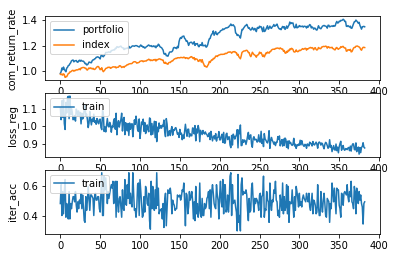

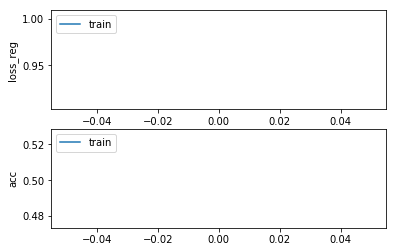

Epochs :  0 Iterations :  383 Loss :  0.9560861064622047 ACC :  0.50105975976812 MCC :  0.005867464686123844 Precision :  0.5134396701078502
mode : validation


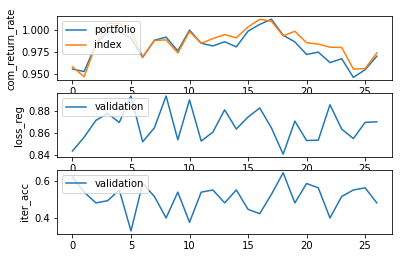

Epochs :  0 Iterations :  27 Loss :  0.8669889083615056 ACC :  0.5102396684664267 MCC :  nan Precision :  0.4951593338477391


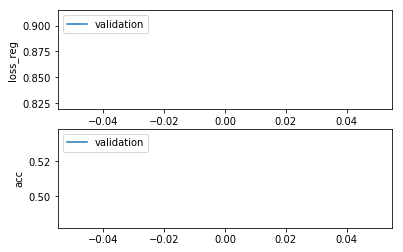

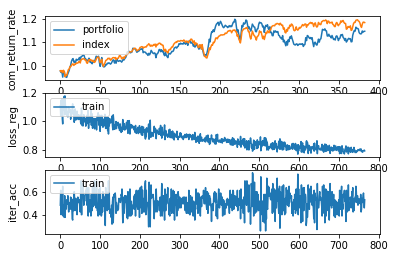

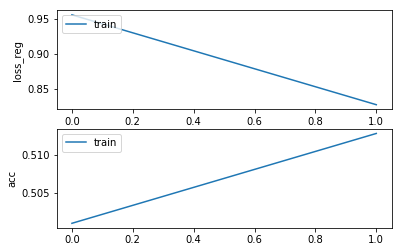

Epochs :  1 Iterations :  766 Loss :  0.826687831635886 ACC :  0.5127630326361943 MCC :  0.021216541978557334 Precision :  0.5197911949988756
mode : validation


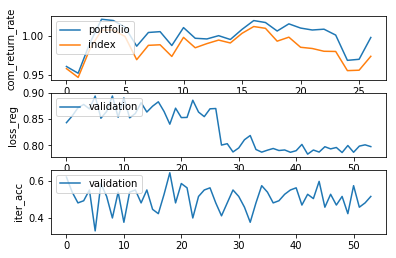

Epochs :  1 Iterations :  27 Loss :  0.79495119827765 ACC :  0.5023965294714328 MCC :  nan Precision :  0.49691537850432926


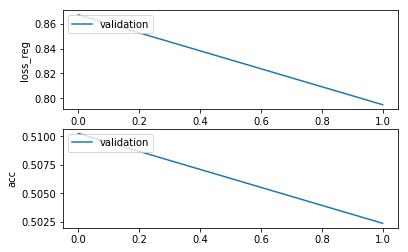

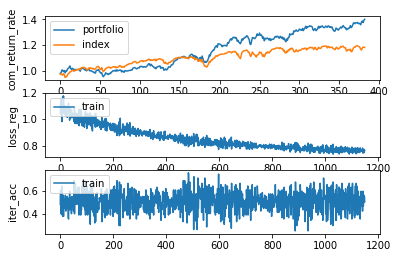

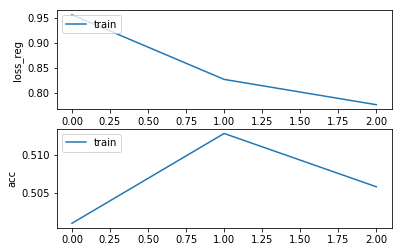

Epochs :  2 Iterations :  1149 Loss :  0.7759027747199057 ACC :  0.5058209339725753 MCC :  0.014970684433465352 Precision :  0.5163313800045933
mode : validation


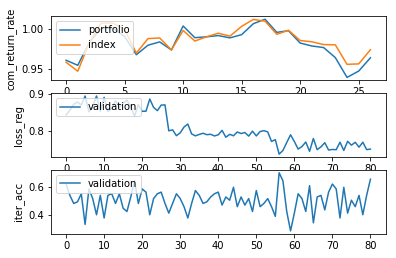

Epochs :  2 Iterations :  27 Loss :  0.7612806779366953 ACC :  0.5015250709321764 MCC :  nan Precision :  0.49329182257254917


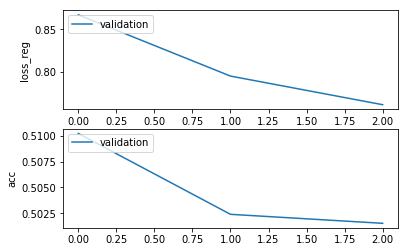

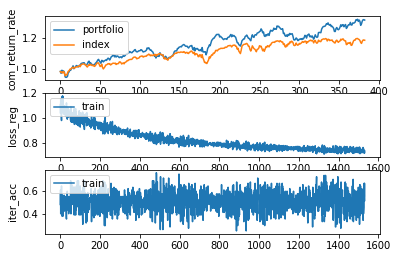

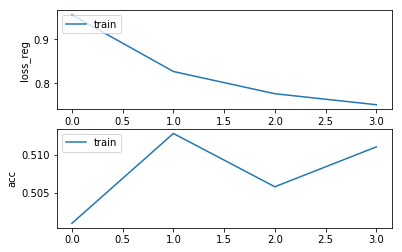

Epochs :  3 Iterations :  1532 Loss :  0.7508144335086913 ACC :  0.5110121487637412 MCC :  0.019393021314539863 Precision :  0.5186183386416644
mode : validation


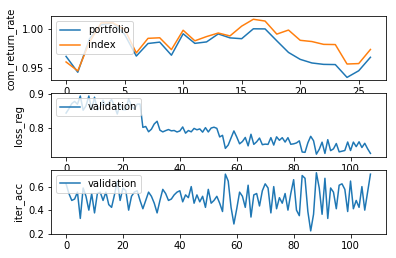

Epochs :  3 Iterations :  27 Loss :  0.7434228746979324 ACC :  0.5089324762423834 MCC :  nan Precision :  0.49237920799189144


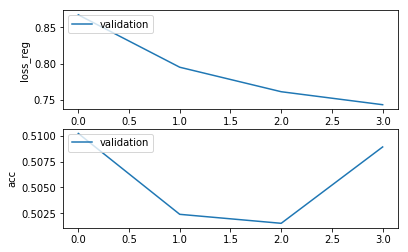

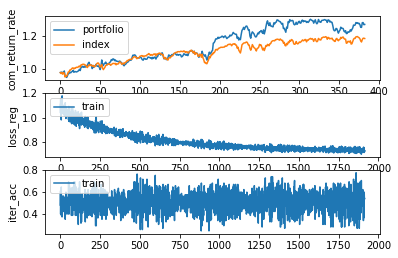

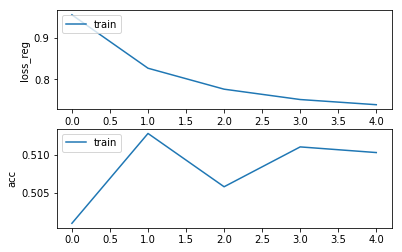

Epochs :  4 Iterations :  1915 Loss :  0.7382705164951693 ACC :  0.5102749350176778 MCC :  0.02494931996796358 Precision :  0.5204182726236221
mode : validation


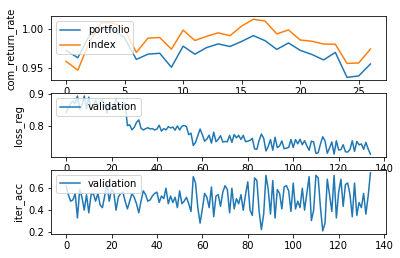

Epochs :  4 Iterations :  27 Loss :  0.7341728364979779 ACC :  0.504575178027153 MCC :  nan Precision :  0.4943136528686241


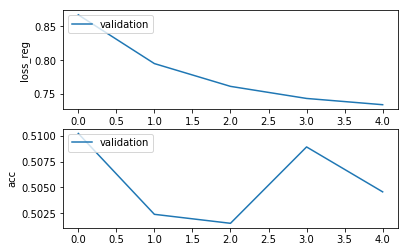

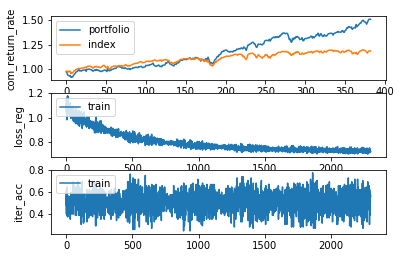

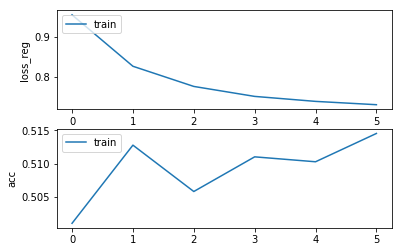

Epochs :  5 Iterations :  2298 Loss :  0.7299061556086528 ACC :  0.5145139154970801 MCC :  0.030186280840399916 Precision :  0.5220531408891432
mode : validation


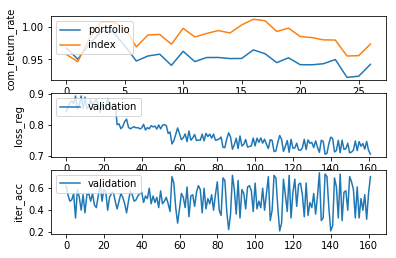

Epochs :  5 Iterations :  27 Loss :  0.7295725963733815 ACC :  0.4971677721650512 MCC :  nan Precision :  0.49172544810507035


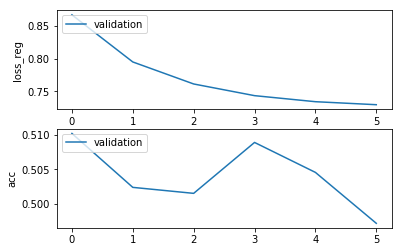

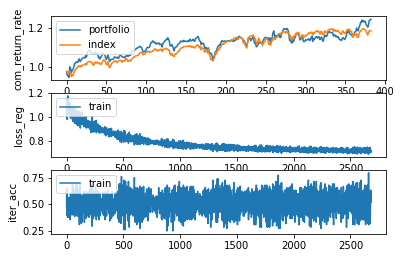

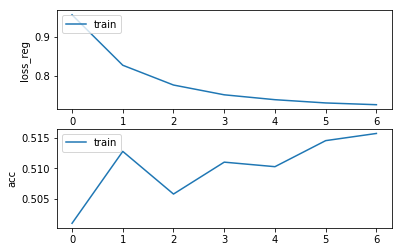

Epochs :  6 Iterations :  2681 Loss :  0.7253919657776935 ACC :  0.5156811709970469 MCC :  0.028154930632680597 Precision :  0.5208241055833842
mode : validation


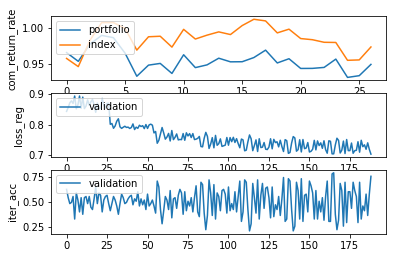

Epochs :  6 Iterations :  27 Loss :  0.7257260945108202 ACC :  0.5032679885625839 MCC :  nan Precision :  0.49189436642660034


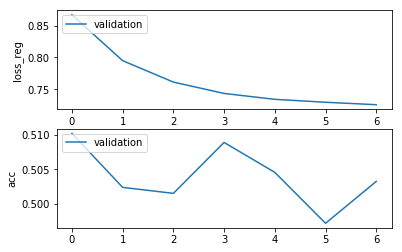

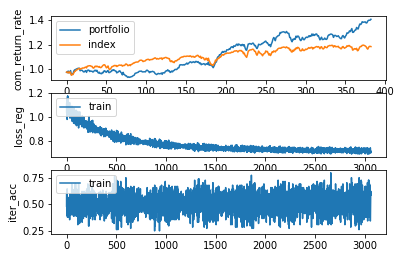

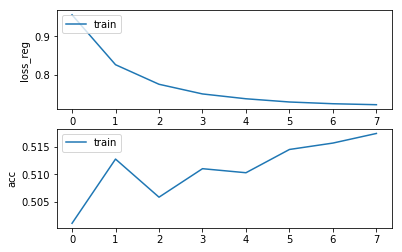

Epochs :  7 Iterations :  3064 Loss :  0.7228703280964346 ACC :  0.5174320541691843 MCC :  0.02895084529198395 Precision :  0.5210482557170463
mode : validation


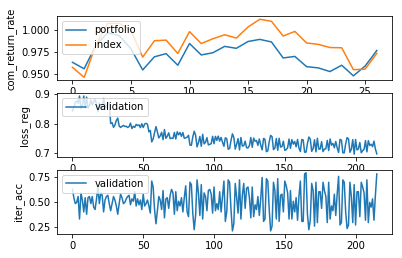

Epochs :  7 Iterations :  27 Loss :  0.7235584259033203 ACC :  0.4928104728460312 MCC :  nan Precision :  0.49370960725678337


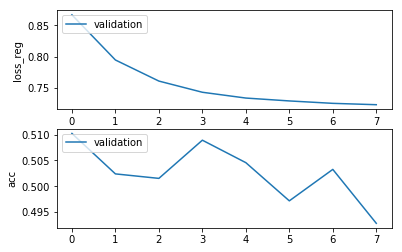

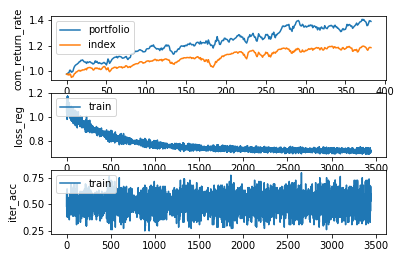

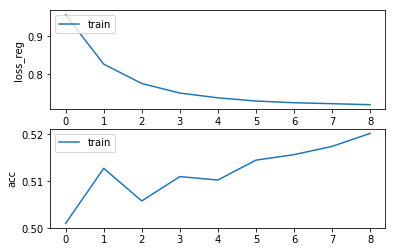

Epochs :  8 Iterations :  3447 Loss :  0.7202170744888465 ACC :  0.5201966066895826 MCC :  0.041158282140564106 Precision :  0.5248123729752264
mode : validation


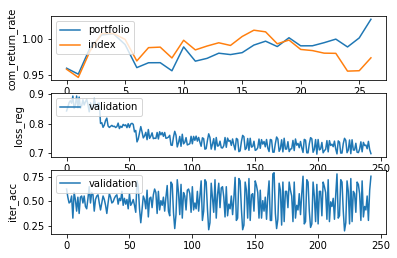

Epochs :  8 Iterations :  27 Loss :  0.7214151488410102 ACC :  0.5006536096334457 MCC :  nan Precision :  0.4941314889325036


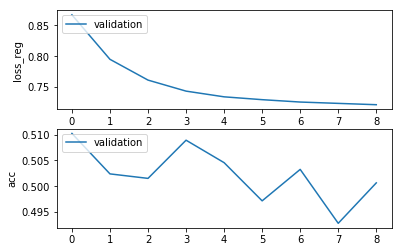

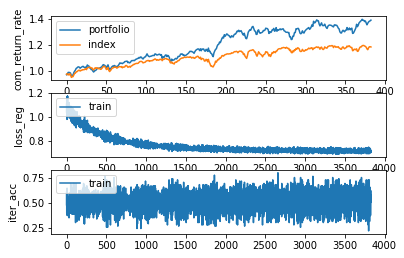

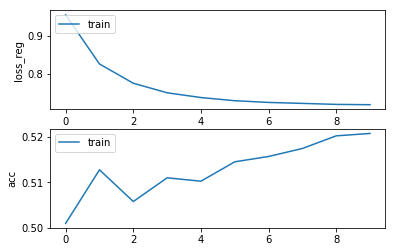

Epochs :  9 Iterations :  3830 Loss :  0.7194076343865058 ACC :  0.5207187998310393 MCC :  0.04124437959247096 Precision :  0.5247085198040263
mode : validation


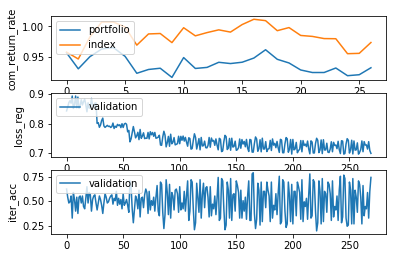

Epochs :  9 Iterations :  27 Loss :  0.7208154422265513 ACC :  0.49629631141821545 MCC :  nan Precision :  0.49099735501739716


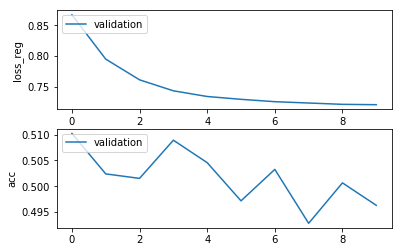

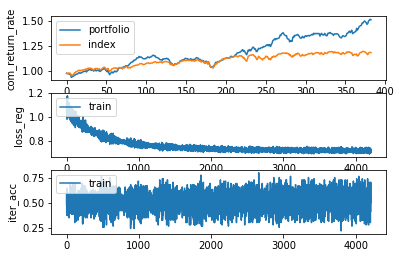

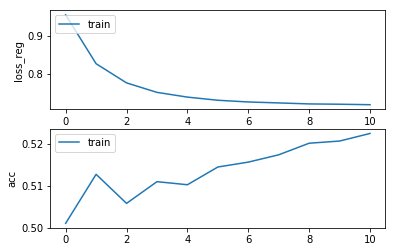

Epochs :  10 Iterations :  4213 Loss :  0.7181475215418843 ACC :  0.5225311180785804 MCC :  0.041664666009734945 Precision :  0.525649447295591
mode : validation


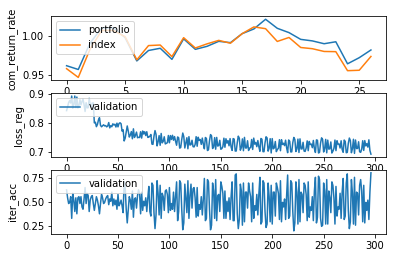

Epochs :  10 Iterations :  27 Loss :  0.7200089693069458 ACC :  0.5050109078486761 MCC :  nan Precision :  0.4934173503683673


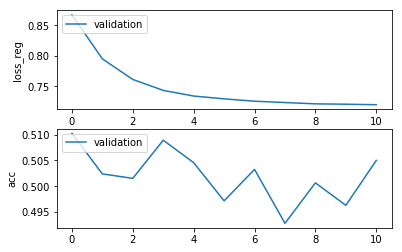

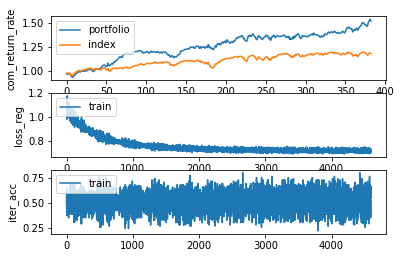

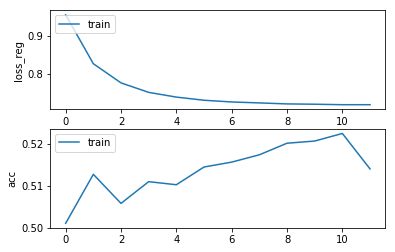

Epochs :  11 Iterations :  4596 Loss :  0.7181274203034045 ACC :  0.514053157586653 MCC :  0.024824842828564227 Precision :  0.5196279391121148
mode : validation


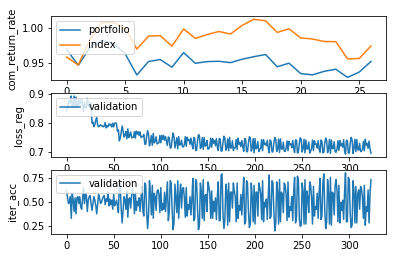

Epochs :  11 Iterations :  27 Loss :  0.7201989778765926 ACC :  0.4919390132029851 MCC :  nan Precision :  0.492460948449594


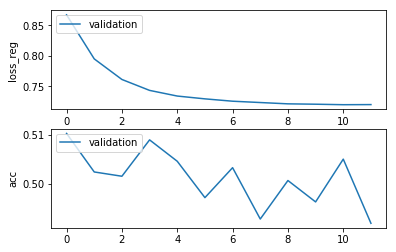

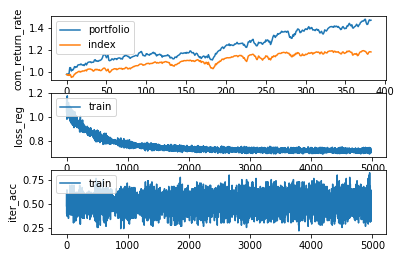

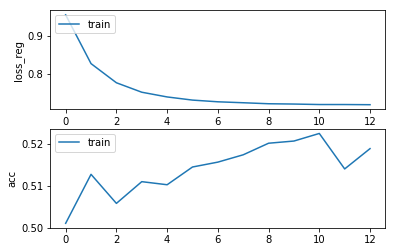

Epochs :  12 Iterations :  4979 Loss :  0.7176748766289056 ACC :  0.518906482206001 MCC :  0.03691070300603514 Precision :  0.5231633176176028
mode : validation


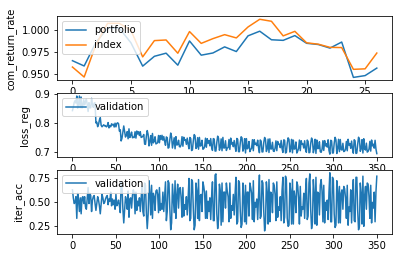

Epochs :  12 Iterations :  27 Loss :  0.7199437927316736 ACC :  0.5032679874587942 MCC :  nan Precision :  0.49639215347943483


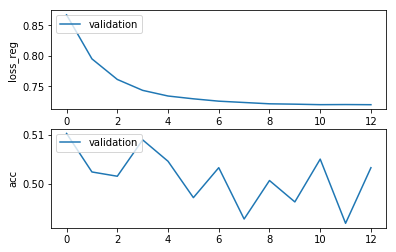

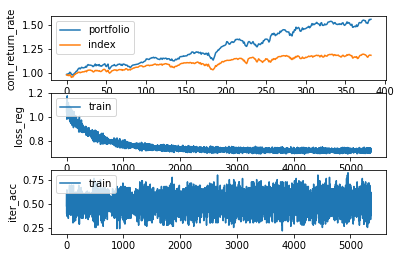

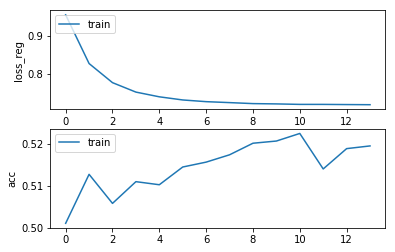

Epochs :  13 Iterations :  5362 Loss :  0.7173023142951587 ACC :  0.5195515447590432 MCC :  0.03948376783186219 Precision :  0.5241300804934442
mode : validation


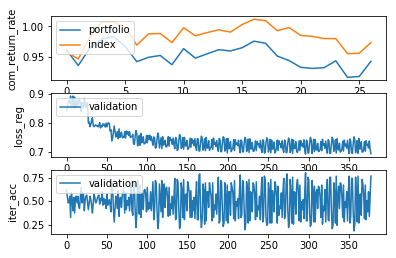

Epochs :  13 Iterations :  27 Loss :  0.7198308066085533 ACC :  0.5002178809157124 MCC :  nan Precision :  0.493409189913008


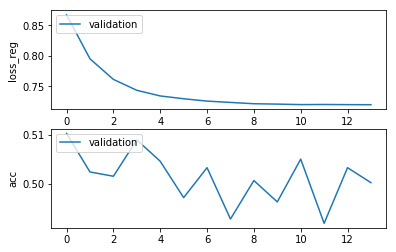

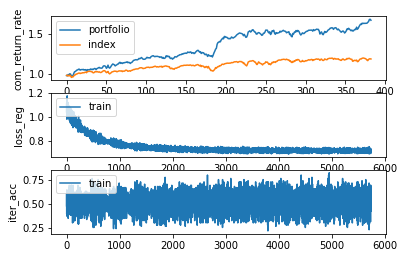

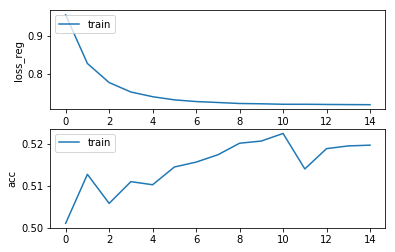

Epochs :  14 Iterations :  5745 Loss :  0.7169930631435882 ACC :  0.5197358478843076 MCC :  0.038049157977884746 Precision :  0.5234249806707584
mode : validation


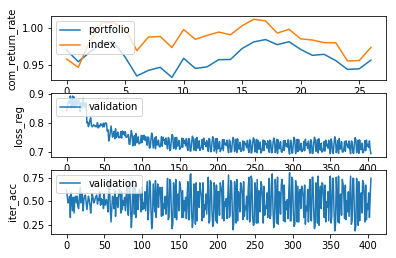

Epochs :  14 Iterations :  27 Loss :  0.719245868700522 ACC :  0.4919390120991954 MCC :  nan Precision :  0.4907956371014869


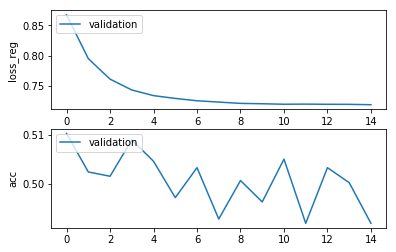

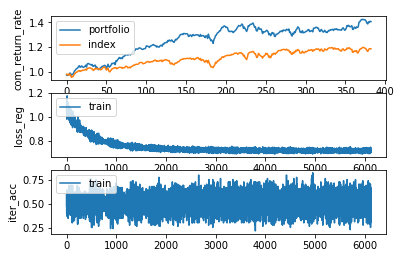

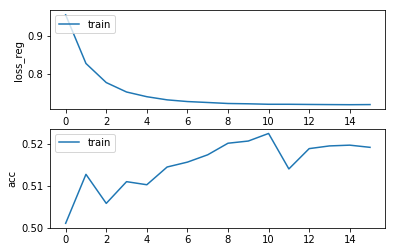

Epochs :  15 Iterations :  6128 Loss :  0.7173362133085883 ACC :  0.519213654198161 MCC :  0.038405955886448837 Precision :  0.5234327271249991
mode : validation


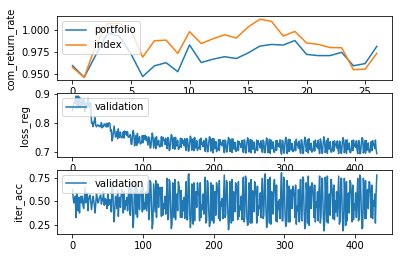

Epochs :  15 Iterations :  27 Loss :  0.7189236592363428 ACC :  0.5084967469727552 MCC :  nan Precision :  0.496633000947811


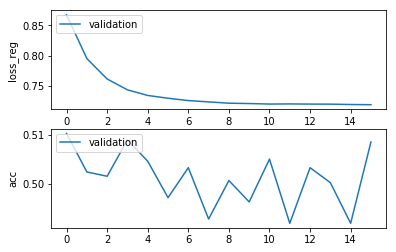

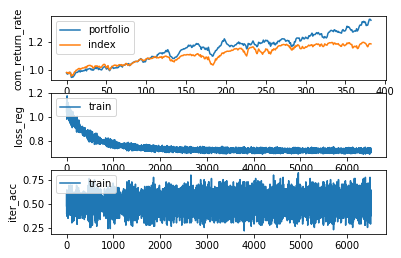

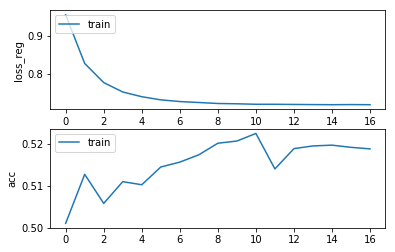

Epochs :  16 Iterations :  6511 Loss :  0.7169955540886125 ACC :  0.5188450476363807 MCC :  0.03687129153760014 Precision :  0.5234146256135976
mode : validation


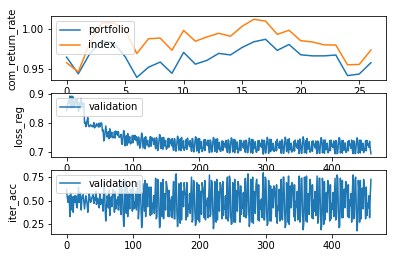

Epochs :  16 Iterations :  27 Loss :  0.7193282246589661 ACC :  0.49934642016887665 MCC :  nan Precision :  0.49236831827848043


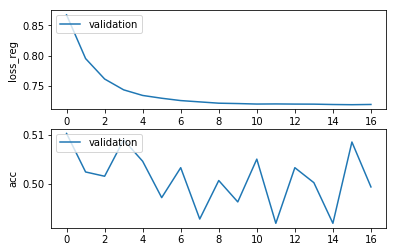

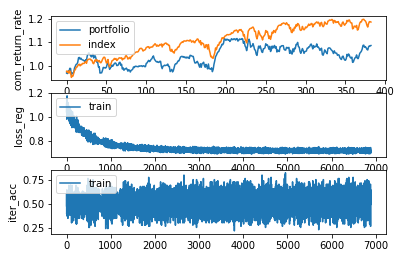

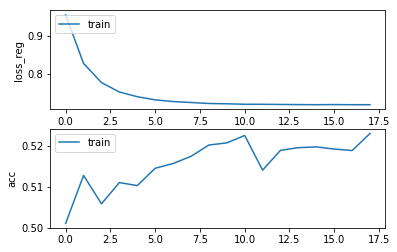

Epochs :  17 Iterations :  6894 Loss :  0.7170278423760018 ACC :  0.5230225937796013 MCC :  0.043248109898667335 Precision :  0.5257342291543596
mode : validation


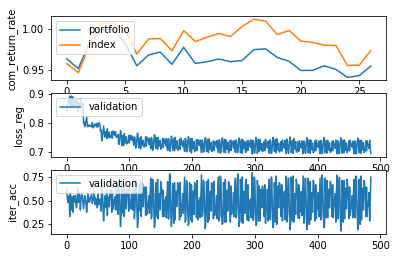

Epochs :  17 Iterations :  27 Loss :  0.7191279000706143 ACC :  0.5019607979942251 MCC :  nan Precision :  0.49187162290844655


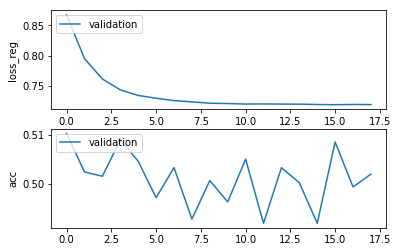

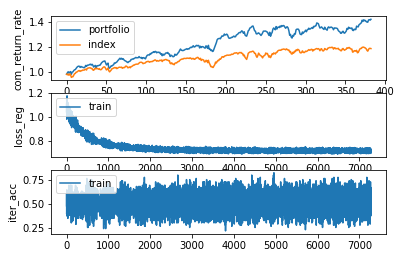

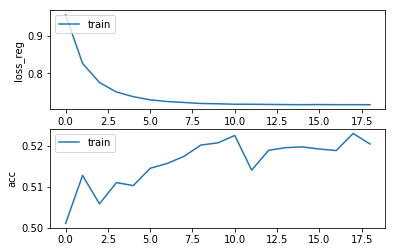

Epochs :  18 Iterations :  7277 Loss :  0.7169430380390456 ACC :  0.5204423437230581 MCC :  0.03948615212905325 Precision :  0.5235307210370626
mode : validation


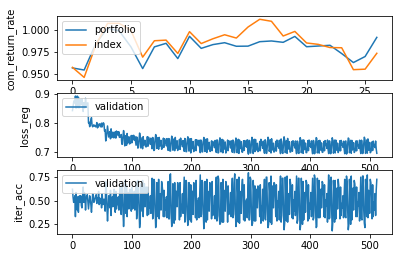

Epochs :  18 Iterations :  27 Loss :  0.7192568867294876 ACC :  0.5106753955284754 MCC :  nan Precision :  0.49525597622549095


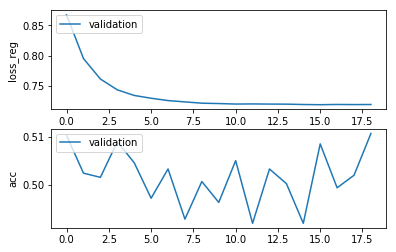

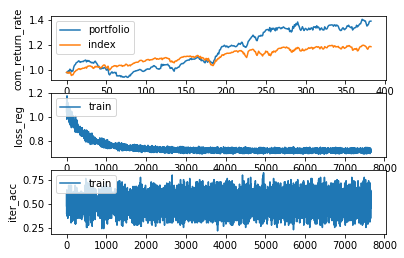

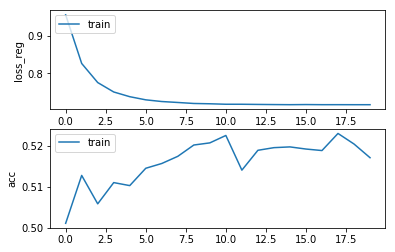

Epochs :  19 Iterations :  7660 Loss :  0.7169583572108814 ACC :  0.5170941642308048 MCC :  0.03331091160814256 Precision :  0.5225514267077646
mode : validation


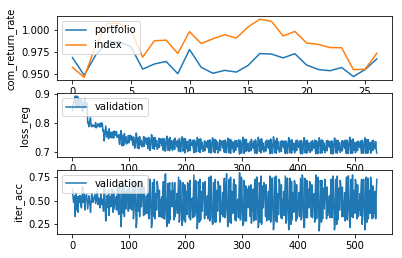

Epochs :  19 Iterations :  27 Loss :  0.7193516073403535 ACC :  0.4976035003308897 MCC :  nan Precision :  0.49111839452827416


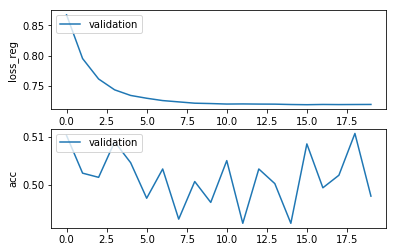

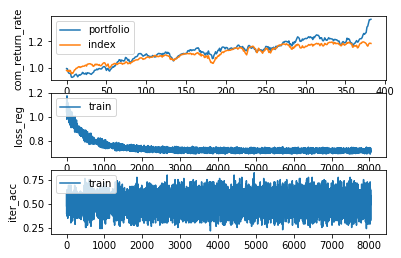

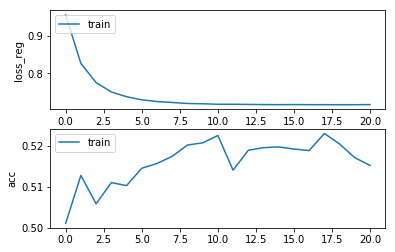

Epochs :  20 Iterations :  8043 Loss :  0.7172835245144896 ACC :  0.5152204125808362 MCC :  0.029287510157888632 Precision :  0.5208409606933827
mode : validation


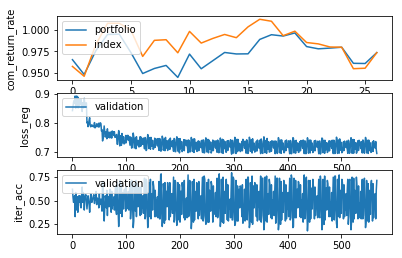

Epochs :  20 Iterations :  27 Loss :  0.7185978580404211 ACC :  0.5006536107372355 MCC :  nan Precision :  0.4957224130630493


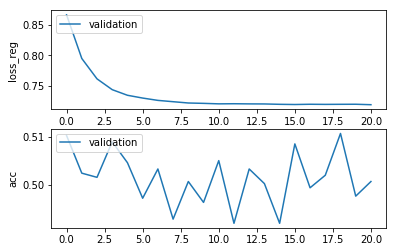

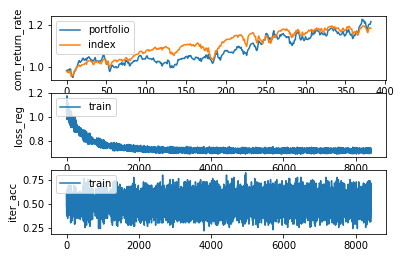

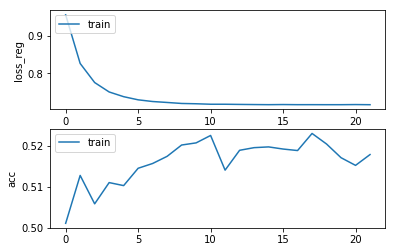

Epochs :  21 Iterations :  8426 Loss :  0.7169099068828414 ACC :  0.5178620955729297 MCC :  0.036420885179411895 Precision :  0.5232158354860451
mode : validation


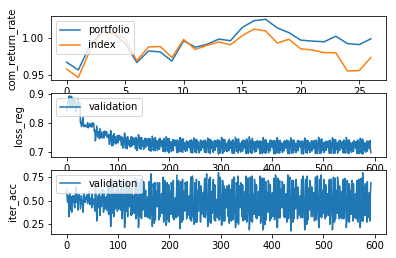

Epochs :  21 Iterations :  27 Loss :  0.7192320073092425 ACC :  0.49803923070430756 MCC :  nan Precision :  0.49231723447640735


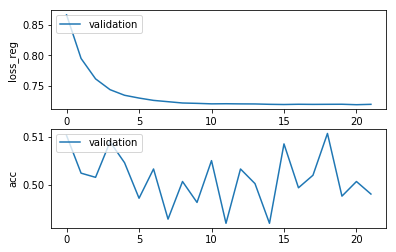

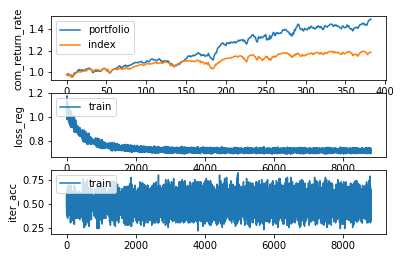

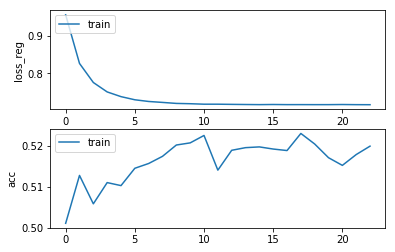

Epochs :  22 Iterations :  8809 Loss :  0.7167825350250961 ACC :  0.5199201511651977 MCC :  0.03790523151592923 Precision :  0.5237861864618938
mode : validation


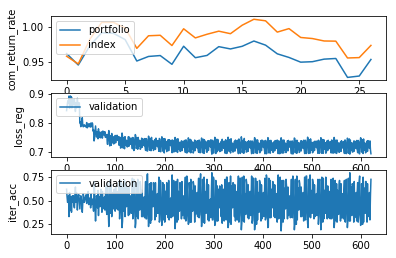

Epochs :  22 Iterations :  27 Loss :  0.7188153156527767 ACC :  0.4954248512232745 MCC :  nan Precision :  0.4920490989116607


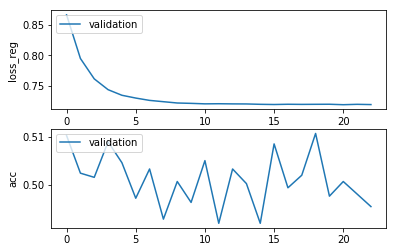

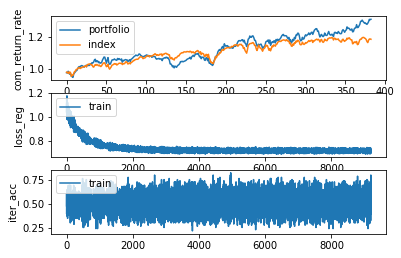

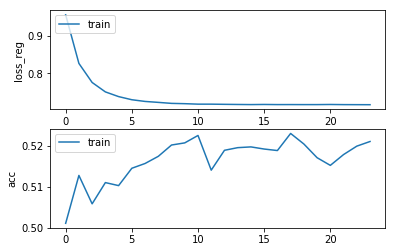

Epochs :  23 Iterations :  9192 Loss :  0.7166763928478131 ACC :  0.5210566893803544 MCC :  0.04004256785044802 Precision :  0.5240475130376866
mode : validation


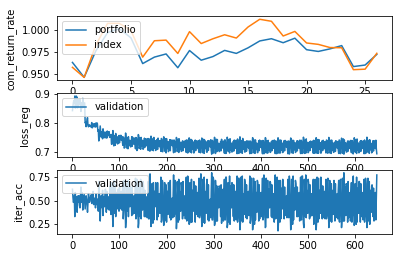

Epochs :  23 Iterations :  27 Loss :  0.7191089435859963 ACC :  0.49455339158022843 MCC :  nan Precision :  0.49358392520635214


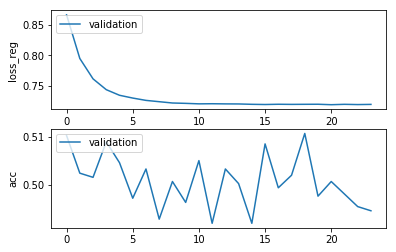

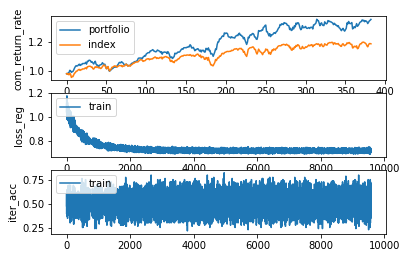

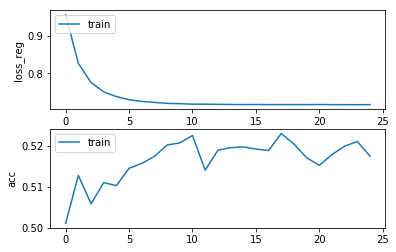

Epochs :  24 Iterations :  9575 Loss :  0.7168528789328533 ACC :  0.5174627713761816 MCC :  0.03393577189973796 Precision :  0.5222494771640854
mode : validation


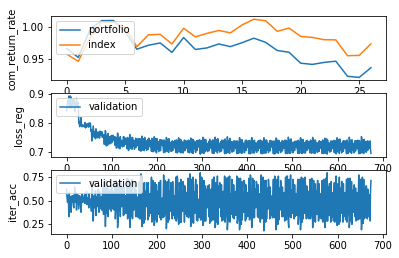

Epochs :  24 Iterations :  27 Loss :  0.7195133588932179 ACC :  0.48932463537763665 MCC :  nan Precision :  0.48899713655312854


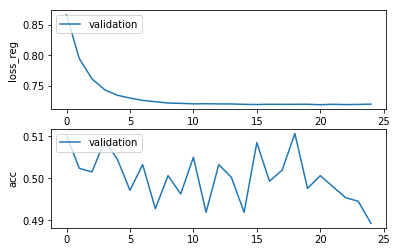

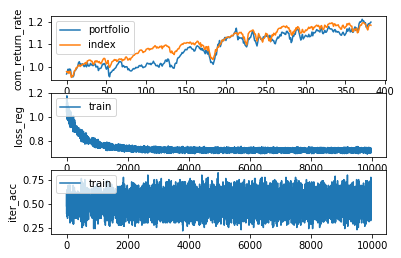

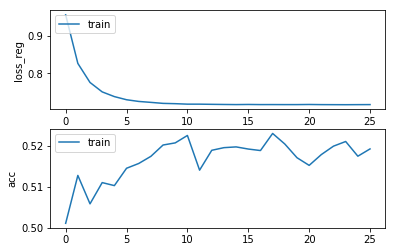

Epochs :  25 Iterations :  9958 Loss :  0.7169750034030984 ACC :  0.5192443721443804 MCC :  0.033299255106864406 Precision :  0.5225834168649374
mode : validation


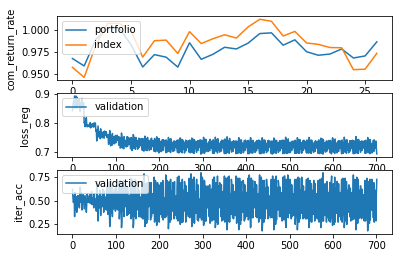

Epochs :  25 Iterations :  27 Loss :  0.7193211670275088 ACC :  0.4958605815966924 MCC :  nan Precision :  0.49296363732881016


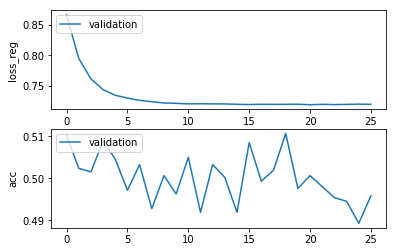

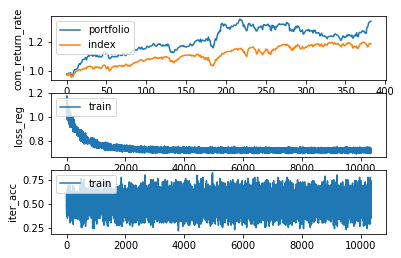

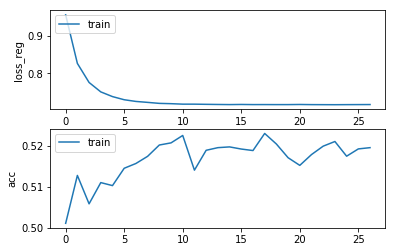

Epochs :  26 Iterations :  10341 Loss :  0.717101334280507 ACC :  0.5195515440198211 MCC :  0.03729205601787871 Precision :  0.5231351422160553
mode : validation


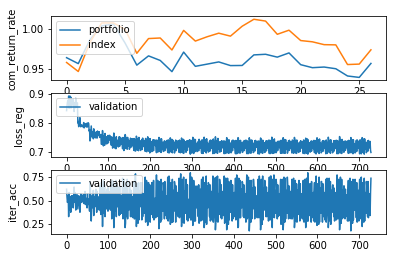

Epochs :  26 Iterations :  27 Loss :  0.7193158666292826 ACC :  0.5058823674917221 MCC :  nan Precision :  0.49367089307418577


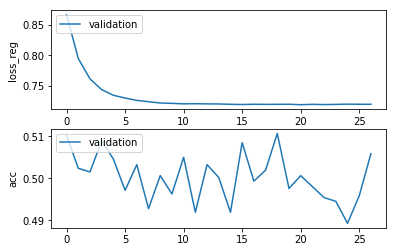

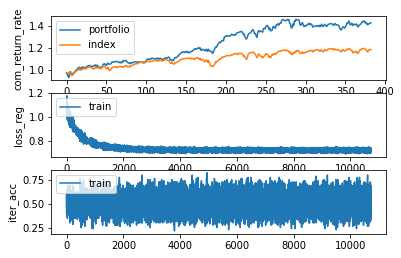

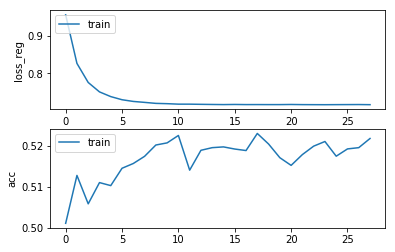

Epochs :  27 Iterations :  10724 Loss :  0.7167572081867148 ACC :  0.5217939039434527 MCC :  0.041782278180767976 Precision :  0.5252777222719034
mode : validation


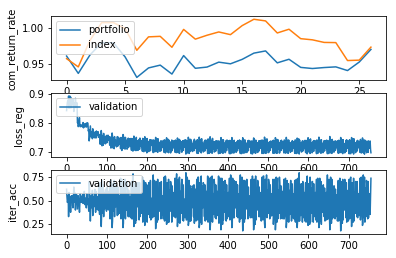

Epochs :  27 Iterations :  27 Loss :  0.7187989530739961 ACC :  0.5093682060639063 MCC :  nan Precision :  0.4960972255578748


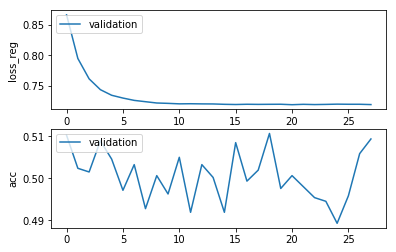

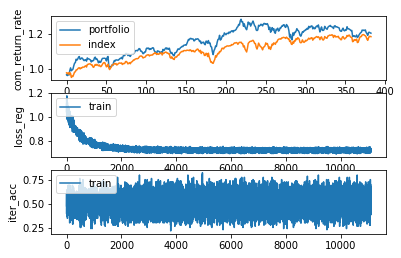

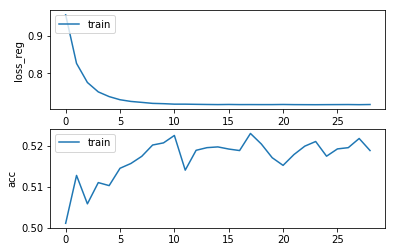

Epochs :  28 Iterations :  11107 Loss :  0.7171843565475224 ACC :  0.5188450474029421 MCC :  0.038325255748258985 Precision :  0.5234293147834023
mode : validation


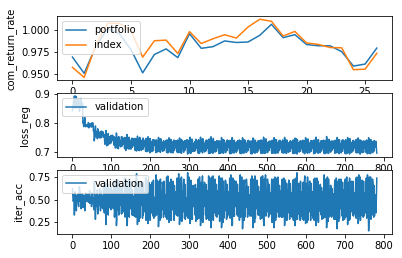

Epochs :  28 Iterations :  27 Loss :  0.7196842586552655 ACC :  0.49629631141821545 MCC :  nan Precision :  0.48930827776590985


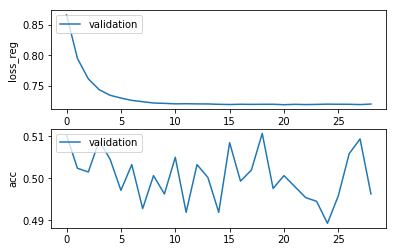

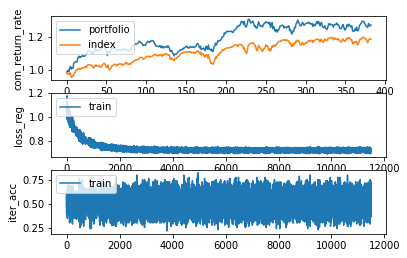

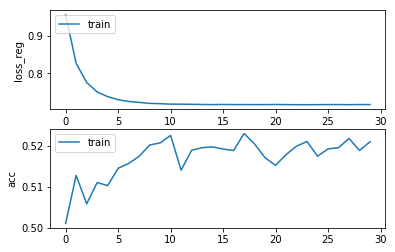

Epochs :  29 Iterations :  11490 Loss :  0.7169700313174694 ACC :  0.5209952553943306 MCC :  0.040037488826555404 Precision :  0.5239510758689971
mode : validation


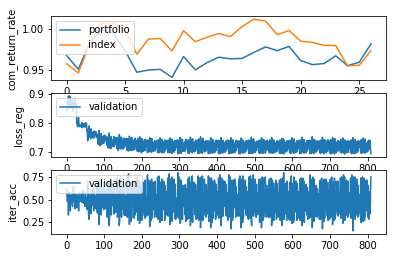

Epochs :  29 Iterations :  27 Loss :  0.7193623118930392 ACC :  0.5023965289195379 MCC :  nan Precision :  0.4932516988504816


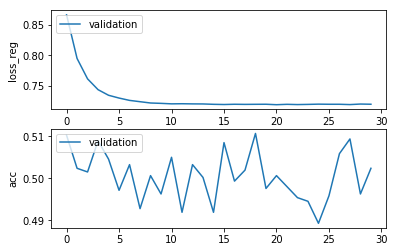

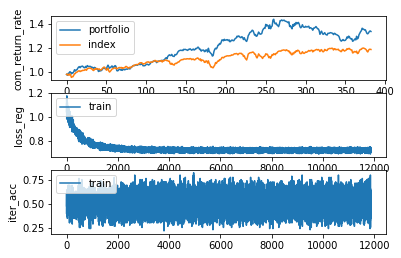

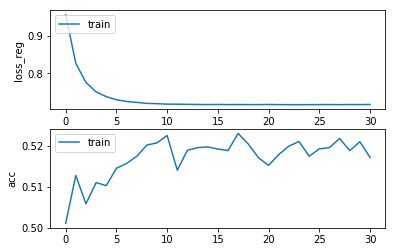

Epochs :  30 Iterations :  11873 Loss :  0.7173502856072806 ACC :  0.5171555984502673 MCC :  0.03295314404414359 Precision :  0.5217096343655966
mode : validation


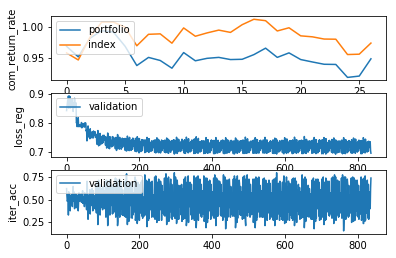

Epochs :  30 Iterations :  27 Loss :  0.7192131921097085 ACC :  0.5002178792600278 MCC :  nan Precision :  0.4947242676107972


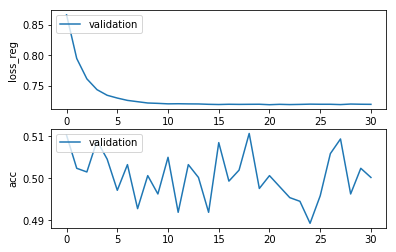

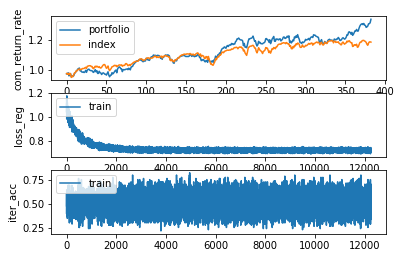

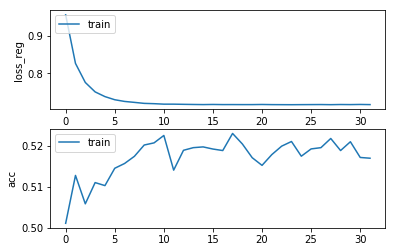

Epochs :  31 Iterations :  12256 Loss :  0.7169370344662479 ACC :  0.5169712956362542 MCC :  0.035493533248288495 Precision :  0.5228398757653588
mode : validation


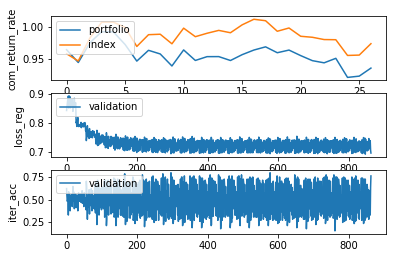

Epochs :  31 Iterations :  27 Loss :  0.7194955393120095 ACC :  0.4910675530080442 MCC :  nan Precision :  0.4919486092748465


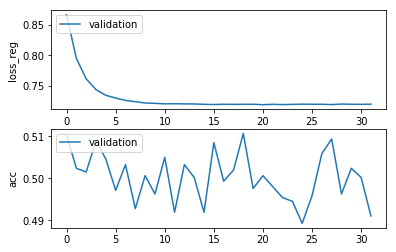

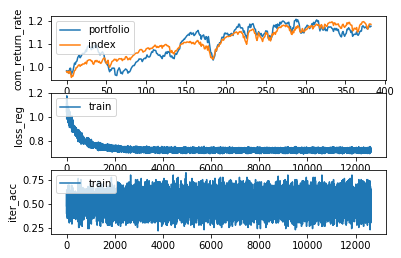

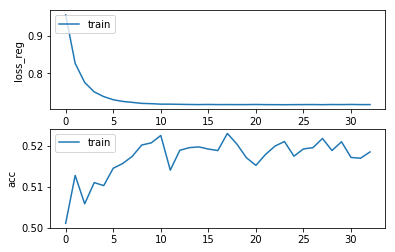

Epochs :  32 Iterations :  12639 Loss :  0.7170116286676173 ACC :  0.5185071579703463 MCC :  0.032434733554735466 Precision :  0.5214868739402948
mode : validation


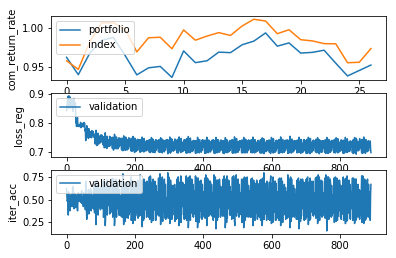

Epochs :  32 Iterations :  27 Loss :  0.7191339554610076 ACC :  0.5006536090815509 MCC :  nan Precision :  0.49578891528977287


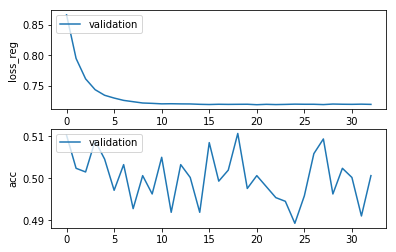

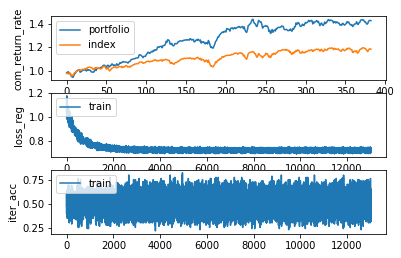

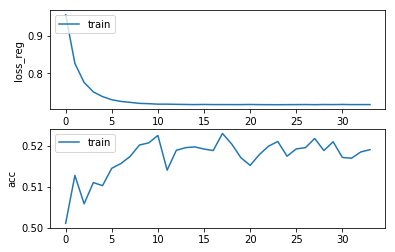

Epochs :  33 Iterations :  13022 Loss :  0.7169806387654795 ACC :  0.5190600680464553 MCC :  0.03222987790228483 Precision :  0.5218502587198667
mode : validation


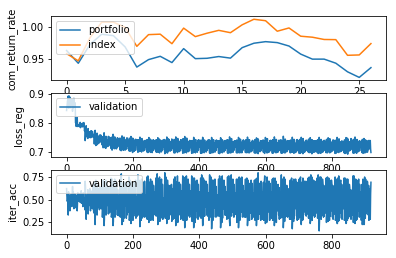

Epochs :  33 Iterations :  27 Loss :  0.7188548445701599 ACC :  0.49542485067137965 MCC :  nan Precision :  0.49271117771665257


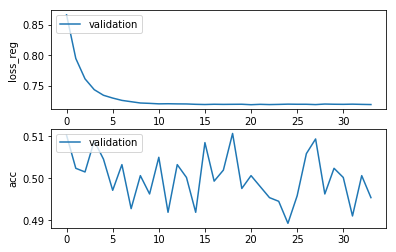

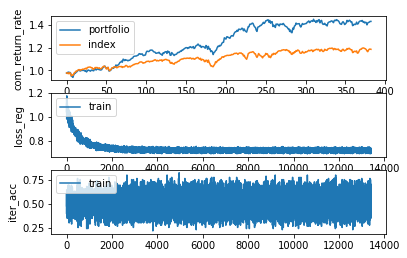

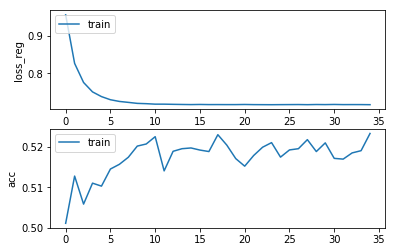

Epochs :  34 Iterations :  13405 Loss :  0.7167322215461233 ACC :  0.5233297657717613 MCC :  0.044140811629323456 Precision :  0.5254954030401713
mode : validation


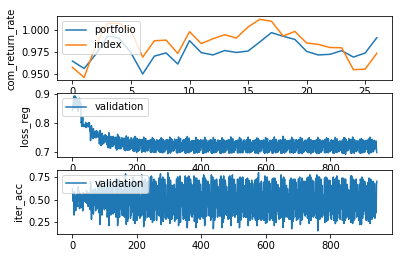

Epochs :  34 Iterations :  27 Loss :  0.7193175201062803 ACC :  0.49978214999039966 MCC :  nan Precision :  0.4951802758430993


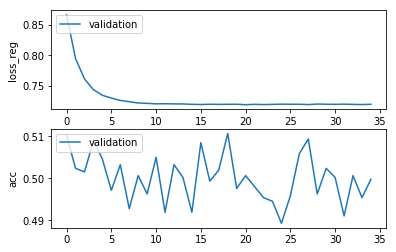

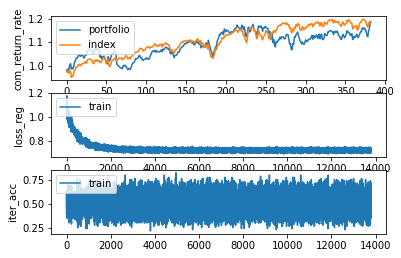

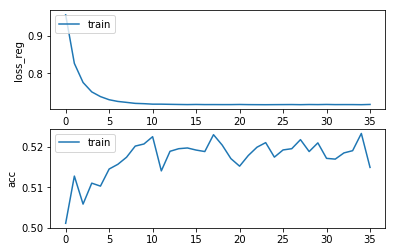

Epochs :  35 Iterations :  13788 Loss :  0.7173679881867789 ACC :  0.5149132400050799 MCC :  0.02508025943023802 Precision :  0.520231912243265
mode : validation


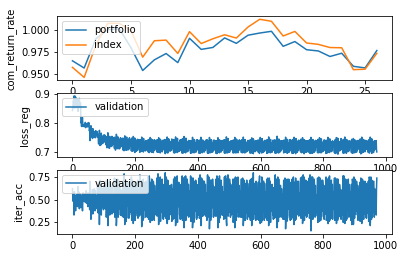

Epochs :  35 Iterations :  27 Loss :  0.7192424999343024 ACC :  0.5006536096334457 MCC :  nan Precision :  0.4900533768037955


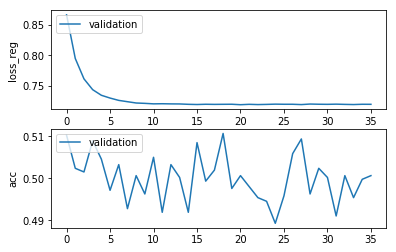

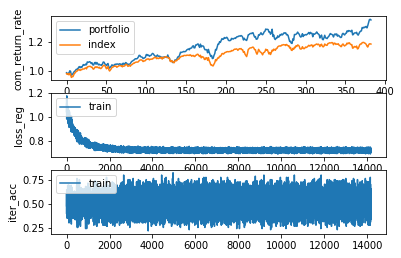

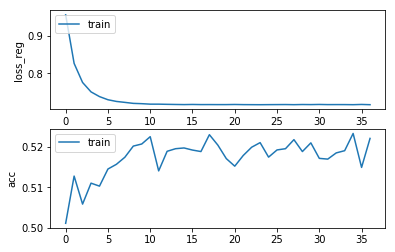

Epochs :  36 Iterations :  14171 Loss :  0.7167065501524326 ACC :  0.5221010762468642 MCC :  0.0414735069699031 Precision :  0.5246921930530208
mode : validation


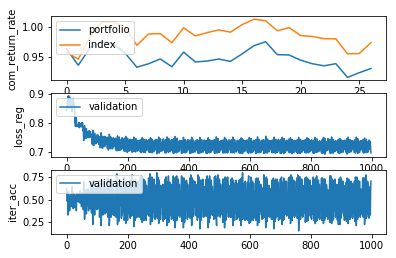

Epochs :  36 Iterations :  27 Loss :  0.7189582608364247 ACC :  0.49934642016887665 MCC :  nan Precision :  0.4912991365072904


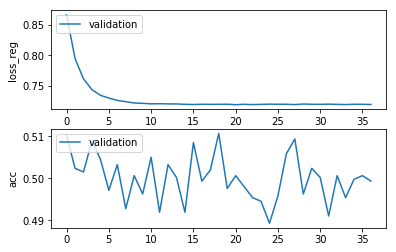

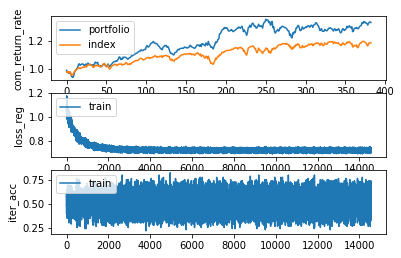

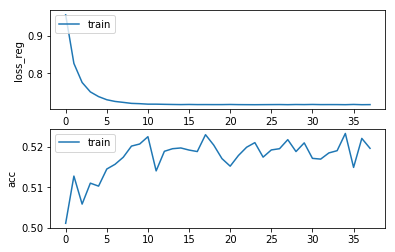

Epochs :  37 Iterations :  14554 Loss :  0.7169156312631253 ACC :  0.5196436962633157 MCC :  0.03755915129080648 Precision :  0.5237175838744593
mode : validation


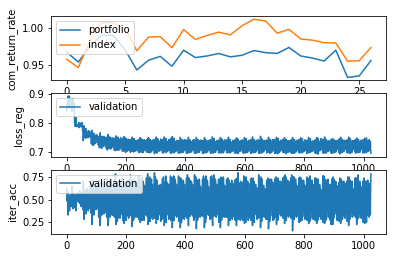

Epochs :  37 Iterations :  27 Loss :  0.7191058529747857 ACC :  0.5032679874587942 MCC :  nan Precision :  0.49604487888239046


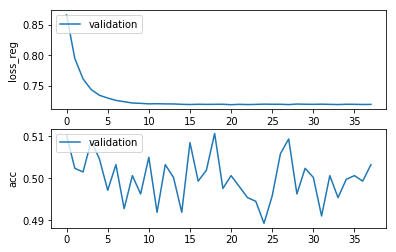

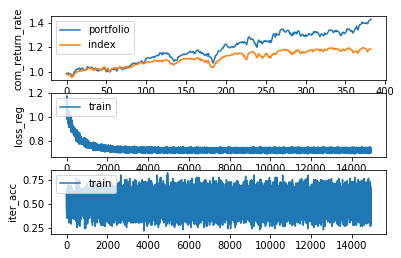

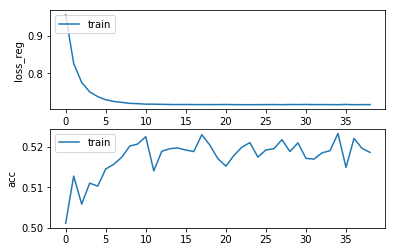

Epochs :  38 Iterations :  14937 Loss :  0.7169474528290273 ACC :  0.5186300273819319 MCC :  0.036179840598770906 Precision :  0.523373937530944
mode : validation


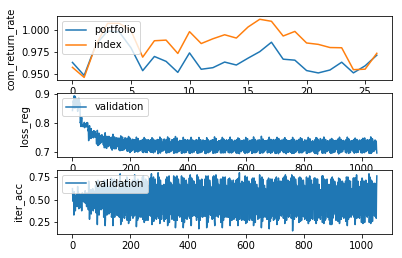

Epochs :  38 Iterations :  27 Loss :  0.7193631485656455 ACC :  0.4989106897954588 MCC :  nan Precision :  0.4916603541760533


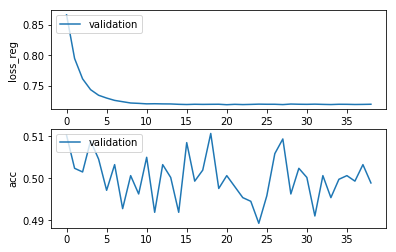

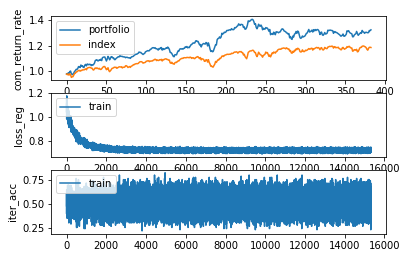

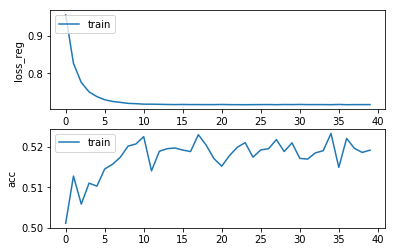

Epochs :  39 Iterations :  15320 Loss :  0.7169799677074422 ACC :  0.5191829366020995 MCC :  0.0371739402624314 Precision :  0.5231721444643898
mode : validation


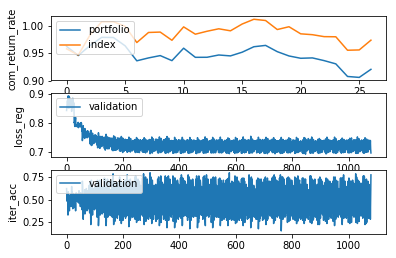

Epochs :  39 Iterations :  27 Loss :  0.7194772252330074 ACC :  0.5023965278157482 MCC :  nan Precision :  0.4950775548263832


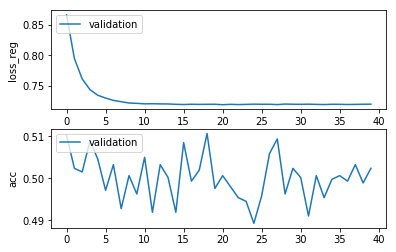

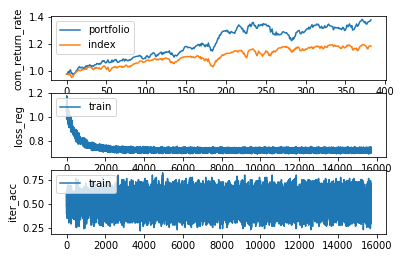

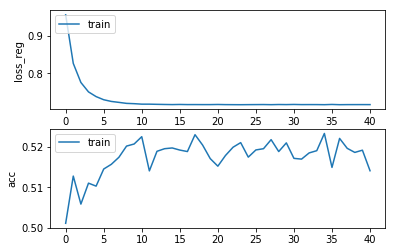

Epochs :  40 Iterations :  15703 Loss :  0.7169232318669013 ACC :  0.5140838739377089 MCC :  0.02693618588877827 Precision :  0.520548441765864
mode : validation


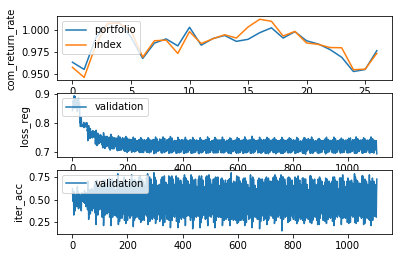

Epochs :  40 Iterations :  27 Loss :  0.7190328461152536 ACC :  0.4928104728460312 MCC :  nan Precision :  0.4911308030563372


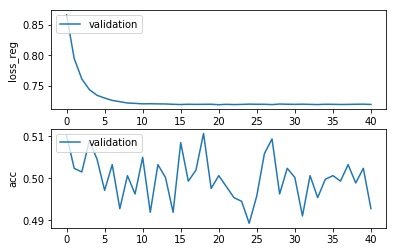

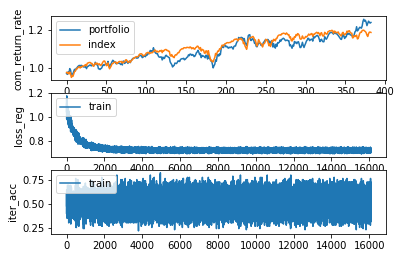

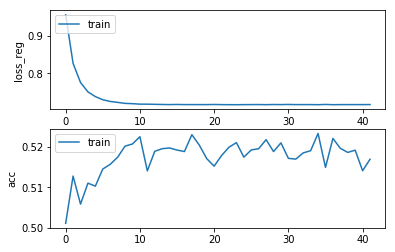

Epochs :  41 Iterations :  16086 Loss :  0.7170974112677512 ACC :  0.5169405777289413 MCC :  0.029462093372790352 Precision :  0.5209366789831739
mode : validation


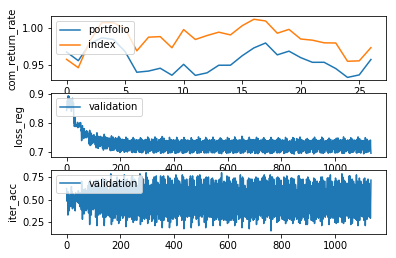

Epochs :  41 Iterations :  27 Loss :  0.7190177992538169 ACC :  0.49978214999039966 MCC :  nan Precision :  0.4926153167530342


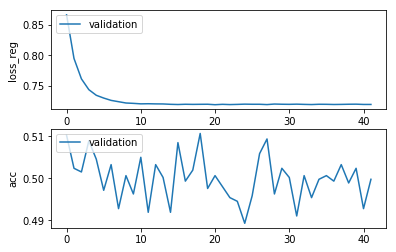

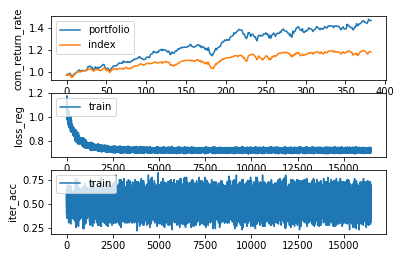

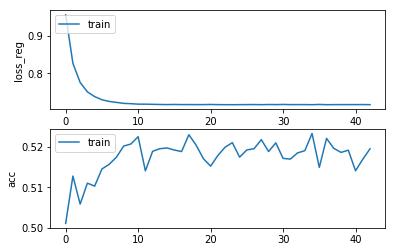

Epochs :  42 Iterations :  16469 Loss :  0.7167789187506036 ACC :  0.5195208258012567 MCC :  0.035016702729862126 Precision :  0.5225033939040361
mode : validation


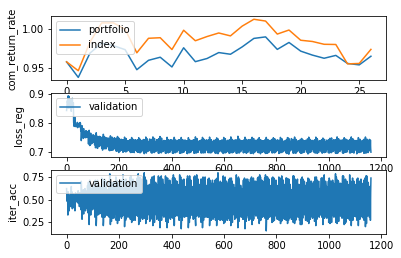

Epochs :  42 Iterations :  27 Loss :  0.7194393343395658 ACC :  0.5015250687245969 MCC :  nan Precision :  0.493910965130285


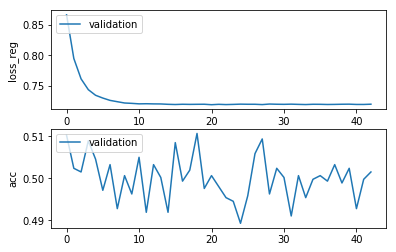

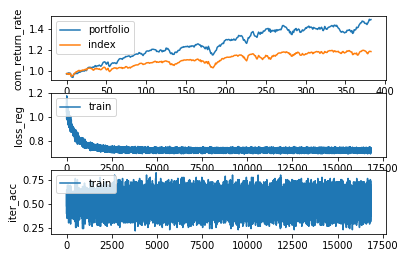

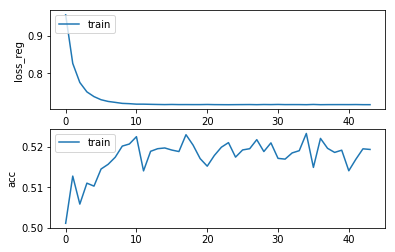

Epochs :  43 Iterations :  16852 Loss :  0.716753035083452 ACC :  0.5193672402720538 MCC :  0.034610231851978965 Precision :  0.5220521216526355
mode : validation


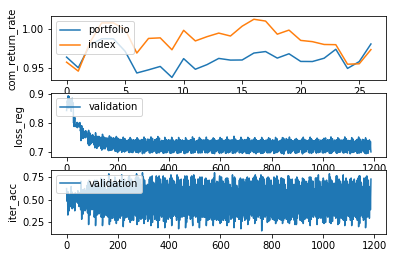

Epochs :  43 Iterations :  27 Loss :  0.7185288182011357 ACC :  0.5037037189360019 MCC :  nan Precision :  0.4929621372785833


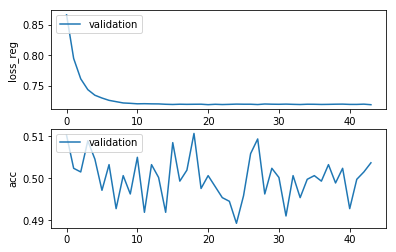

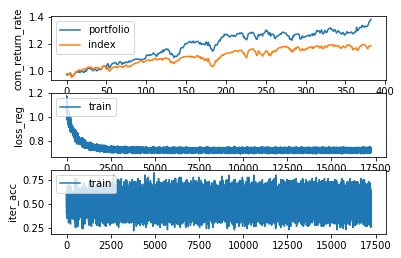

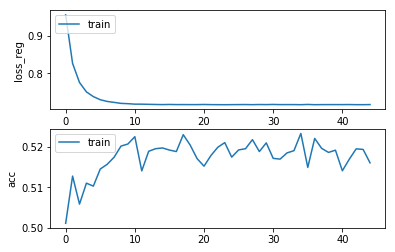

Epochs :  44 Iterations :  17235 Loss :  0.7170415880163407 ACC :  0.5160497777922658 MCC :  0.0318012191788184 Precision :  0.521686193866378
mode : validation


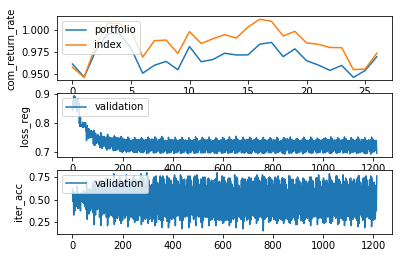

Epochs :  44 Iterations :  27 Loss :  0.7187950831872446 ACC :  0.49934642016887665 MCC :  nan Precision :  0.4934551100488062


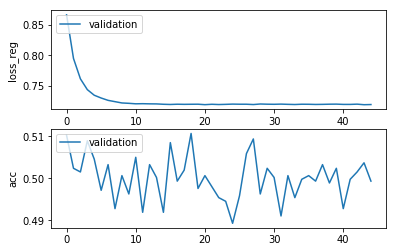

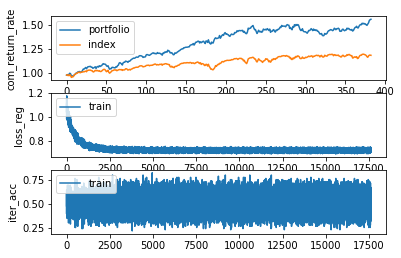

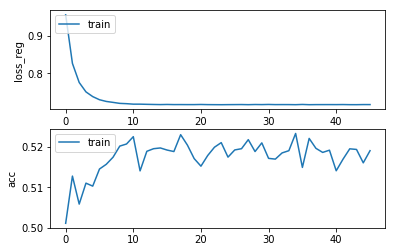

Epochs :  45 Iterations :  17618 Loss :  0.7169921832358557 ACC :  0.5190600687467709 MCC :  0.035567438423082805 Precision :  0.5227829268732286
mode : validation


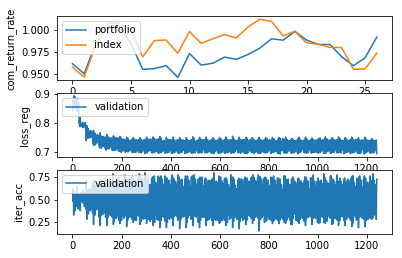

Epochs :  45 Iterations :  27 Loss :  0.7184414642828482 ACC :  0.5084967469727552 MCC :  nan Precision :  0.49423748558318176


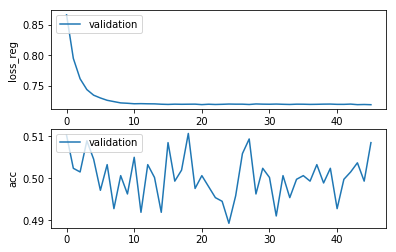

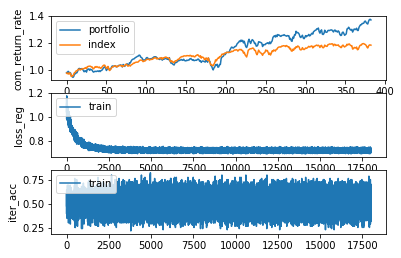

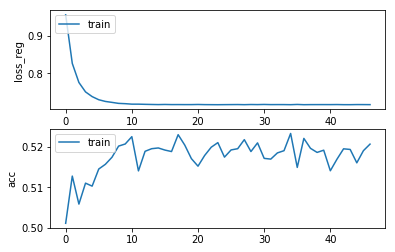

Epochs :  46 Iterations :  18001 Loss :  0.7168599339129097 ACC :  0.5206880827796677 MCC :  0.0391964041673537 Precision :  0.5239426365156242
mode : validation


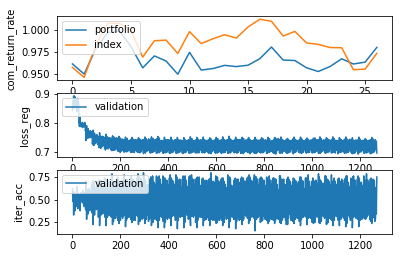

Epochs :  46 Iterations :  27 Loss :  0.7191323991175051 ACC :  0.4958605815966924 MCC :  nan Precision :  0.4903950147606708


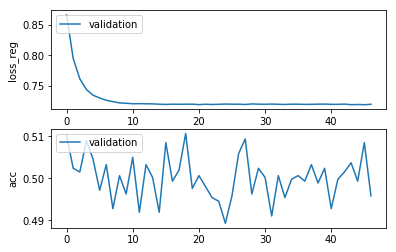

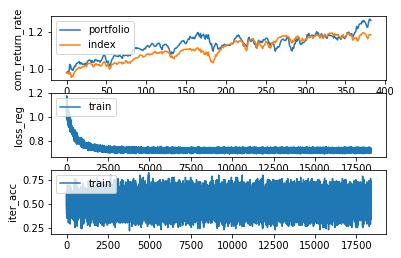

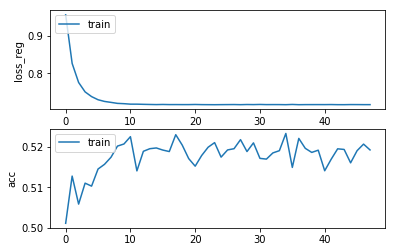

Epochs :  47 Iterations :  18384 Loss :  0.7168489973165347 ACC :  0.519244371833129 MCC :  0.03673031605298658 Precision :  0.5235831264853866
mode : validation


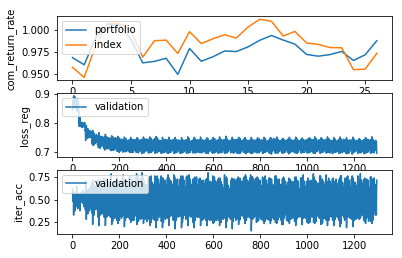

Epochs :  47 Iterations :  27 Loss :  0.7187353085588526 ACC :  0.5084967464208603 MCC :  nan Precision :  0.49601019035886834


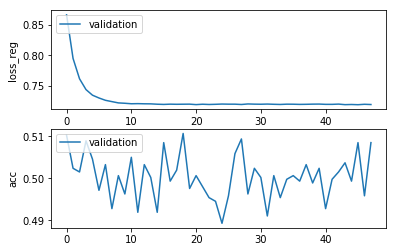

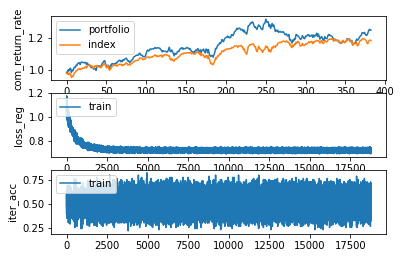

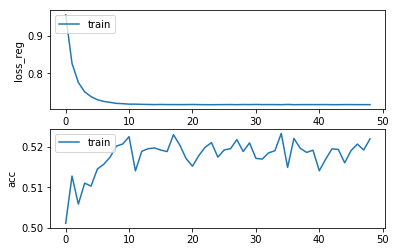

Epochs :  48 Iterations :  18767 Loss :  0.7168288143745601 ACC :  0.5219782071076237 MCC :  0.040783331430226555 Precision :  0.5247147065580047
mode : validation


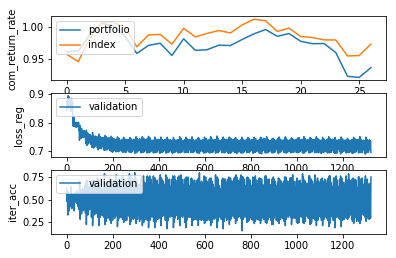

Epochs :  48 Iterations :  27 Loss :  0.7187452934406422 ACC :  0.5028322592929557 MCC :  nan Precision :  0.4951430501209365


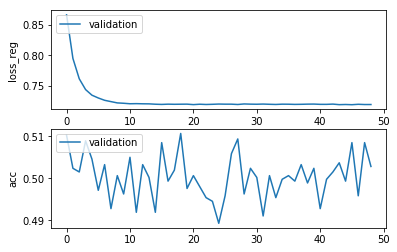

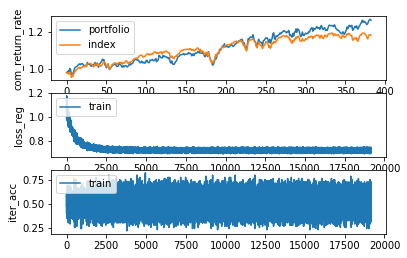

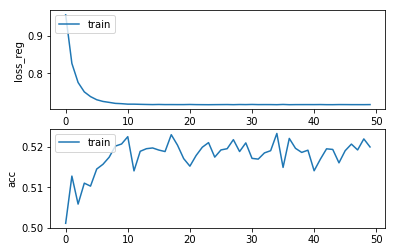

Epochs :  49 Iterations :  19150 Loss :  0.7169831441836942 ACC :  0.519981585734818 MCC :  0.037112172381002846 Precision :  0.5235453744421351
mode : validation


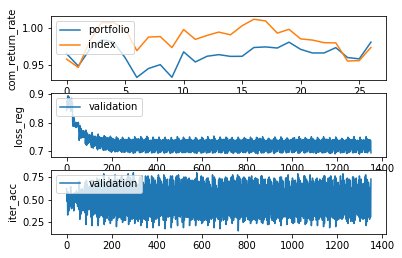

Epochs :  49 Iterations :  27 Loss :  0.7194384976669594 ACC :  0.5037037178322121 MCC :  nan Precision :  0.4938827924154423


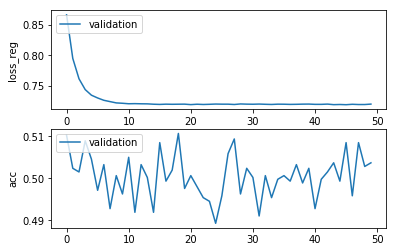

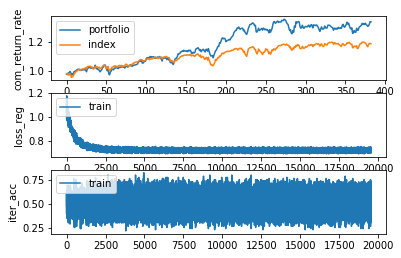

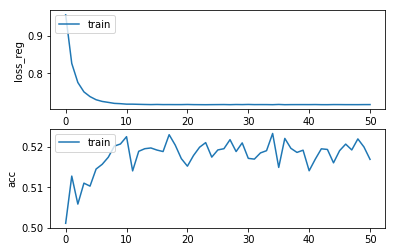

Epochs :  50 Iterations :  19533 Loss :  0.7170063207417182 ACC :  0.516909860794289 MCC :  0.028791075467506505 Precision :  0.520988325707556
mode : validation


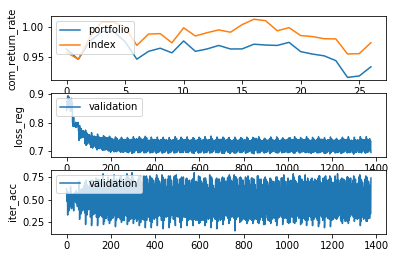

Epochs :  50 Iterations :  27 Loss :  0.7190617477452313 ACC :  0.5080610171512321 MCC :  nan Precision :  0.49677719093031353


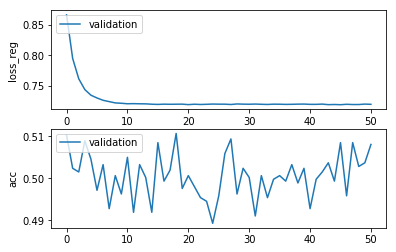

KeyboardInterrupt: 

In [16]:
model.train()

epoch :  0 time_idx :  0 loss_reg :  tensor(0.7021, grad_fn=<AddBackward0>) acc :  tensor(0.6941) mcc :  tensor(0.1759) precision :  tensor(0.9310)


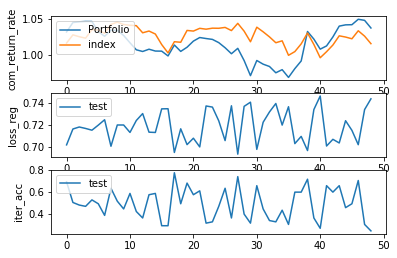

Epochs :  0 Iterations :  49 Loss :  0.7190518573838838 ACC :  0.4941176604859683 MCC :  0.013144501015705494 Precision :  0.4773444096956934


In [17]:
model.test()

In [ ]:
model.train()

In [ ]:
model.test()

In [ ]:
model.train() # dropout 없음, epochs = 5

In [ ]:
model.train() # dropout 0.15 적용

In [ ]:
model.test()

In [ ]:
model.test()

In [ ]:
model.train()

In [ ]:
model.train()

In [ ]:
model.test()

In [ ]:
model.epoch_losses

In [ ]:
model.train()

In [ ]:
model.test()

In [ ]:
model.return_rate.shape

In [ ]:
ㄴmodel.train()

In [ ]:
model.train()